In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm as tqdm
import pickle
from scipy.stats import gaussian_kde

d:\Users\Heijden\Miniconda3\envs\data-analysis\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
datapath = Path().resolve().parent.parent.parent / 'data' / 'optimization data' /  'sensitivity analysis'#'optimization data'#'sensitivity analysis'
datapath

WindowsPath('D:/Users/Heijden/Documents/PhD work/Current work/DR_IJmuiden/data/optimization data/sensitivity analysis')

In [3]:
parameters = [(shape, n, cvar, alpha) for shape in ['tree', 'fan'] for n in [2, 3, 5, 10, 25] for cvar in [-0.395, -0.3, -0.2] for alpha in [0.99, 0.95, 0.9, 0.8, 0.5]]

In [4]:
def read_pkl(datapath, shape, n, cvar, alpha):
    if (cvar == -0.4) & (alpha == 1):
        name = f'robust_energy_{n}_{shape}'
    else:
        name = f'cvar_{alpha}_{-1*cvar}_energy_{n}_{shape}'
    try:
        return pd.read_pickle(datapath / name / 'simulation_data.pkl')
    except:
        return None

In [5]:
class ResultPlotter():
    def __init__(self, df, cvar, var, alpha, plotind=None):
        self.df = df
        self.cvar = cvar
        self.alpha = alpha
        self.var = var

        if plotind is None:
            self.plotind = df.index[1:]#df.dropna().index[1:]
        else:
            self.plotind = plotind

        self.colorlist = [
            '#377eb8', '#ff7f00', '#4daf4a',
            '#f781bf', '#a65628', '#984ea3',
            '#999999', '#e41a1c', '#dede00'
        ]

    def plot_waterbalance(self, plotax=None, figsize=(4,2)):
        if plotax is None:
            fig, ax = plt.subplots(figsize=figsize)
        else:
            ax = plotax

        self.df.loc[self.plotind, 'Q_gate'].plot(drawstyle='steps-post', ax=ax, color=self.colorlist[5], label='Gate discharge')
        self.df.loc[self.plotind, 'Q_pump'].plot(drawstyle='steps-post', ax=ax, color=self.colorlist[1], label='Pump discharge')
        self.df.loc[self.plotind, 'Q_ark'].plot(drawstyle='steps-post', ax=ax, color=self.colorlist[2], label='ARK discharge')
        self.df.loc[self.plotind, 'Q_wb'].plot(drawstyle='steps-post', ax=ax, color=self.colorlist[3], label='Waterboard discharge')

        ax.set_ylim(0, 600)
        ax.set_ylabel('Discharge [m$^3$/s]')
        ax.set_xlim(self.plotind[0], self.plotind[-1])
        ax_ = ax.twinx()
        ax_.set_ylim(-0.6, -0.2)
        self.df.loc[self.plotind, 'h_ns'].plot(drawstyle='steps-post', ax=ax_, color=self.colorlist[4], label='Water level North Sea')
        self.df.loc[self.plotind, 'h_nzk'].plot(drawstyle='steps-post', ax=ax_, color=self.colorlist[0], label='Water level Noordzeekanaal')
        ax_.set_ylabel('Water level [m+NAP]')
        ax_.legend(['h_ns', 'h_nzk'], loc='upper left')

        if plotax is None:
            ax.set_xlabel('Time [h]')
            return fig, ax
        return [ax, ax_]
    
    def plot_dam_bid(self, plotax=None, figsize=(4,2)):
        if plotax is None:
            fig, ax = plt.subplots(figsize=figsize)
        else:
            ax = plotax
        self.df.loc[self.plotind, 'E_dam'].plot(drawstyle='steps-post', ax=ax, color=self.colorlist[8], label='DAM bid')
        ax.set_ylabel('Energy [MWh hour$^{-1}$]')
        ax.set_ylim(0,None)
        ax.set_xlim(self.plotind[0], self.plotind[-1])
        
        ax_ = ax.twinx()
        self.df.loc[self.plotind, 'p_dam'].plot(drawstyle='steps-post', ax=ax_, color=self.colorlist[6], label='DAM price')
        ax_.set_ylabel('Price [EUR MWh$^{-1}$]')
        ax.axhline(0, color='k', linestyle='--', linewidth=0.5)

        if plotax is None:
            ax.set_xlabel('Time [h]')
            return fig, ax
        return [ax, ax_]
    
    def plot_idm_bid(self, plotax, figsize=(4,2)):
        if plotax is None:
            fig, ax = plt.subplots(figsize=figsize)
        else:
            ax = plotax
        idm_bid = self.df.loc[self.plotind, 'E_act'] - self.df.loc[self.plotind, 'E_dam']
        idm_bid.plot(drawstyle='steps-post', ax=ax, color=self.colorlist[7], label='IDM bid')
        ax.set_ylabel('Energy [MWh hour$^{-1}$]')
        ax.axhline(0, color='k', linestyle='--', linewidth=0.5)
        ax.set_xlim(self.plotind[0], self.plotind[-1])
        # ax.set_ylim(0,10)
        
        ax_ = ax.twinx()
        self.df.loc[self.plotind, 'p_idm'].plot(drawstyle='steps-post', ax=ax_, color=self.colorlist[6], label='IDM price', linestyle=':')
        ax_.set_ylabel('Price [EUR MWh$^{-1}$]')

        if plotax is None:
            ax.set_xlabel('Time [h]')
            return fig, ax
        return [ax, ax_]
    
    def combined_plot(self):
        fig, ax = plt.subplots(3,1, figsize=(10,9))
        axes = []
        ax[0].set_title('Fluxes')
        axes += self.plot_waterbalance(ax[0])
        ax[1].set_title('DAM bids')
        axes += self.plot_dam_bid(ax[1])
        damlims = axes[-1].get_ylim()
        edamlims = axes[-2].get_ylim()
        ax[2].set_title('IDM bids')
        axes += self.plot_idm_bid(ax[2])
        idmlims = axes[-1].get_ylim()
        eactlims = axes[-2].get_ylim()
        pricelims = [min(damlims[0], idmlims[0]), max(damlims[1], idmlims[1])]
        enlims = [min(edamlims[0], eactlims[0]), max(edamlims[1], eactlims[1])]
        axes[3].set_ylim(pricelims)
        axes[5].set_ylim(pricelims)
        axes[2].set_ylim(enlims)
        axes[4].set_ylim(enlims)


        # Get all the handles and labels from the legends
        handles, labels = [], []
        for ax_ in axes:
            for h, l in zip(*ax_.get_legend_handles_labels()):
                handles.append(h)
                labels.append(l)
            
            # Remove the current legend
            ax_.legend().remove()
        
        # Remove duplicates
        by_label = dict(zip(labels, handles))
        
        # Plot the legend below the bottom plot
        ax[-1].legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=4, fancybox=True)
        fig.tight_layout()
        return fig, axes
    
    def plot_wl_distribution(self, ax=None, kde=True):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(4,2))

        if kde:
            self.df.loc[self.plotind, 'h_nzk'].plot(kind='kde', ax=ax)
            ax.axvline(self.cvar, color='k', linestyle='--', linewidth=0.5)
            ax.axvline(self.var, color='k', linestyle='--', linewidth=0.5)
            ax.set_ylabel('Probability density')
        else:
            self.df.loc[self.plotind, 'h_nzk'].plot(kind='hist', bins=100, ax=ax)
            ax.set_ylabel('Frequency')
        ax.set_xlim(-0.5, -0.3)
        ax.set_ylim(0, None)
        ax.set_xlabel('Water level [m+NAP]')
        return ax
    
    def plot_cumulatives(self, axes=None):
        if axes is None:
            fig, axes = plt.subplots(3, 1, figsize=(10,7), sharex=True)
        
        # Cumulative discharges
        q_pump = self.df.loc[self.plotind, 'Q_pump'].dropna()
        q_gate = self.df.loc[self.plotind, 'Q_gate'].dropna()
        q_ark = self.df.loc[self.plotind, 'Q_ark'].dropna()
        q_wb = self.df.loc[self.plotind, 'Q_wb'].dropna()

        q_pump.cumsum().plot(drawstyle='steps-post', ax=axes[0], color=self.colorlist[0], label='Pump discharge')
        q_gate.cumsum().plot(drawstyle='steps-post', ax=axes[0], color=self.colorlist[1], label='Gate discharge')
        q_ark.cumsum().plot(drawstyle='steps-post', ax=axes[0], color=self.colorlist[2], label='Ark discharge')
        q_wb.cumsum().plot(drawstyle='steps-post', ax=axes[0], color=self.colorlist[3], label='Waterboard discharge')
        axes[0].set_ylabel('Cumulative discharge [m$^3$]')
        axes[0].set_xlim(self.plotind[0], self.plotind[-1])
        axes[0].set_ylim(0, None)

        # Cumulative energy
        e_dam = self.df.loc[self.plotind, 'E_dam'].dropna()
        e_act = self.df.loc[self.plotind, 'E_act'].dropna()
        e_idm = e_act - e_dam
        e_dam.cumsum().plot(drawstyle='steps-post', ax=axes[1], color=self.colorlist[4], label='DAM')
        e_idm.cumsum().plot(drawstyle='steps-post', ax=axes[1], color=self.colorlist[5], label='IDM')
        e_act.cumsum().plot(drawstyle='steps-post', ax=axes[1], color=self.colorlist[6], label='Total')
        axes[1].set_ylabel('Cumulative energy [MWh]')
        axes[1].set_xlim(self.plotind[0], self.plotind[-1])
        axes[1].set_ylim(0, None)

        # Cumulative cost
        c_dam = e_dam * self.df.loc[e_dam.index, 'p_dam']
        c_idm = e_idm * self.df.loc[e_idm.index, 'p_idm']
        c_tot = c_dam + c_idm
        c_dam.cumsum().plot(drawstyle='steps-post', ax=axes[2], color=self.colorlist[4], label='DAM')
        c_idm.cumsum().plot(drawstyle='steps-post', ax=axes[2], color=self.colorlist[5], label='IDM')
        c_tot.cumsum().plot(drawstyle='steps-post', ax=axes[2], color=self.colorlist[6], label='Total')
        axes[2].set_ylabel('Cumulative cost [€]')
        axes[2].set_xlim(self.plotind[0], self.plotind[-1])
        # axes[2].set_ylim(0, None)

        # make a shared legend
        handles, labels = [], []
        for ax_ in axes:
            for h, l in zip(*ax_.get_legend_handles_labels()):
                handles.append(h)
                labels.append(l)
            
            # Remove the current legend
            ax_.legend().remove()

        # Remove duplicates
        by_label = dict(zip(labels, handles))

        # Plot the legend below the bottom plot
        axes[-1].legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=4, fancybox=True)
        

        fig.tight_layout()


In [6]:
class SimulationResults():
    
    def __init__(self, df, n_scenarios, shape, cvar, var, alpha, root_wl):
        self.df = df
        self.n_scenarios = n_scenarios
        self.shape = shape
        self.cvar = cvar
        self.var = var
        self.alpha = alpha
        self.root_wl = root_wl
        
        self.plotter = ResultPlotter(
            df=self.df,
            cvar=self.cvar,
            var=self.var,
            alpha=self.alpha,
        )
        

    def __len__(self):
        return len(self.df.dropna())
    
    def plot_cumulatives(self):
        self.plotter.plot_cumulatives()
    
    def plot_fluxes(self):
        self.plotter.combined_plot()
    
    def plot_wl_distribution(self):
        self.plotter.plot_wl_distribution()

    def get_day_ahead_percentage(self, index=None):
        e_dam = self.df['E_dam'].copy()
        e_act = self.df['E_act'].copy()

        if index is not None:
            e_dam = e_dam.loc[index]
            e_act = e_act.loc[index]
        
        return e_dam.sum() / e_act.sum()

    def get_total_energy(self, index=None):
        e_dam = self.df['E_dam']
        e_act = self.df['E_act']

        if index is not None:
            e_dam = e_dam.loc[index]
            e_act = e_act.loc[index]
        
        return e_dam.sum() + e_act.sum()
    
    def _fix_idm_nan(self, df):
        # What to do with IDM? For now fill with 1000
        return df.fillna(0)
    
    def get_cost_ts(self, index=None):
        e_dam = self.df['E_dam'].copy()
        e_act = self.df['E_act'].copy()
        p_dam = self.df['p_dam'].copy()
        p_idm = self.df['p_idm'].copy()
        p_idm = self._fix_idm_nan(p_idm)

        if index is not None:
            e_dam = e_dam.loc[index]
            e_act = e_act.loc[index]
            p_dam = p_dam.loc[index]
            p_idm = p_idm.loc[index]

        e_idm = e_act - e_dam
        c_dam = e_dam * p_dam
        c_idm = e_idm * p_idm
        return c_dam + c_idm
    
    def get_average_energy_cost(self, index=None):
        energy = self.get_total_energy(index=index)
        cost = self.get_total_cost(index=index)
        return cost / energy

    def get_total_cost(self, index=None):
        
        e_dam = self.df['E_dam'].copy()
        e_act = self.df['E_act'].copy()
        p_dam = self.df['p_dam'].copy()
        p_idm = self.df['p_idm'].copy()
        p_idm = self._fix_idm_nan(p_idm)

        if index is not None:
            e_dam = e_dam.loc[index]
            e_act = e_act.loc[index]
            p_dam = p_dam.loc[index]
            p_idm = p_idm.loc[index]

        e_idm = e_act - e_dam
        c_dam = e_dam * p_dam
        c_idm = e_idm * p_idm
        return c_dam.sum() + c_idm.sum()



In [7]:
def monthly_cost_plot(simulation_results):
    # Get the keys at all levels of the dictionary
    shapes = ['fan', 'tree']
    n_scenarios = [1, 2, 3, 5, 10, 25]#, 50, 100]
    cvar = [-0.395, -0.3, -0.2]
    alpha = [0.99, 0.95, 0.9, 0.8, 0.5]

    index = pd.MultiIndex.from_product([cvar, alpha], names=['cvar', 'alpha'])
    # index = pd.MultiIndex.from_product([alpha, cvar], names=['alpha', 'cvar'])
    cols = pd.MultiIndex.from_product([shapes, n_scenarios], names=['shape', 'n_scenarios'])
    monthly_cost = pd.DataFrame(index=index, columns=cols, dtype=float)

    obs_cost = simulation_results['obs'].get_total_cost(index=cost_index)
    for shape in shapes:
        for n in n_scenarios:
            for c in cvar:
                for a in alpha:
                    try:
                        ind = (c, a)
                        # ind = (a, c)
                        monthly_cost.loc[ind, (shape, n)] = simulation_results[shape][n][c][a].get_total_cost(index=cost_index)
                    except:
                        pass
            try:
                monthly_cost.loc['robust', (shape, n)] = simulation_results[shape][n]['robust'].get_total_cost(index=cost_index)
            except:
                pass
    
    return (monthly_cost / obs_cost).round(3)

In [8]:
def DA_percentage_plot(simulation_results, data_index=None):
    # Get the keys at all levels of the dictionary
    shapes = ['fan', 'tree']
    n_scenarios = [1, 2, 3, 5, 10, 25]#, 50, 100]
    cvar = [-0.395, -0.3, -0.2]
    alpha = [0.99, 0.95, 0.9, 0.8, 0.5]

    index = pd.MultiIndex.from_product([cvar, alpha], names=['cvar', 'alpha'])
    # index = pd.MultiIndex.from_product([alpha, cvar], names=['alpha', 'cvar'])
    cols = pd.MultiIndex.from_product([shapes, n_scenarios], names=['shape', 'n_scenarios'])

    percentage_df = pd.DataFrame(index=index, columns=cols, dtype=float)
    percentage_df_rob = pd.DataFrame(index=index, columns=cols, dtype=float)

    for shape in shapes:
        for n in n_scenarios:
            for c in cvar:
                for a in alpha:
                    try:
                        ind = (c, a)
                        # ind = (a, c)
                        percentage_df.loc[ind, (shape, n)] = simulation_results[shape][n][c][a].get_day_ahead_percentage(index=data_index)
                    except:
                        pass
            try:
                percentage_df.loc['robust', (shape, n)] = simulation_results[shape][n]['robust'].get_day_ahead_percentage(index=data_index)
            except:
                pass

    return percentage_df.round(2)


In [9]:
def progress_df(simulation_results, target_index):
    # Get the keys at all levels of the dictionary
    shapes = ['fan', 'tree']
    n_scenarios = [1, 2, 3, 5, 10, 25]#, 50, 100]
    cvar = [-0.395, -0.3, -0.2]
    alpha = [0.99, 0.95, 0.9, 0.8, 0.5]

    index = pd.MultiIndex.from_product([cvar, alpha], names=['cvar', 'alpha'])
    # index = pd.MultiIndex.from_product([alpha, cvar], names=['alpha', 'cvar'])
    cols = pd.MultiIndex.from_product([shapes, n_scenarios], names=['shape', 'n_scenarios'])
    progress_df = pd.DataFrame(index=index, columns=cols, dtype=float)
    progress_df_rob = pd.DataFrame(index=['robust'], columns=cols, dtype=float)

    target_len = len(target_index)
    for shape in shapes:
        for n in n_scenarios:
            for c in cvar:
                for a in alpha:
                    try:
                        ind = (c, a)
                        # ind = (a, c)
                        df = simulation_results[shape][n][c][a].df
                        df = df.loc[df.index.isin(target_index)].dropna()
                        progress_df.loc[ind, (shape, n)] = len(df) / target_len
                    except:
                        pass
            try:
                df = simulation_results[shape][n]['robust'].df
                df = df.loc[df.index.isin(target_index)].dropna()
                progress_df_rob.loc['robust', (shape, n)] = len(df) / target_len
            except:
                pass
    return pd.concat([progress_df, progress_df_rob]).round(2)

## Timeseries simulation

In [10]:
alphas = [0.99, 0.9, 0.8]
cvars = [-0.395, -0.3]
shapes = ['fan', 'tree']
n_scenarios = [3, 5]
wl_root = [-0.4, -0.3]

years = [2019, 2020, 2021]
months = [1, 4, 7, 10]

In [11]:
tspath = Path().resolve().parent.parent.parent / 'data' / 'optimization data' /  'timeseries simulation'

def read_tspkl(datapath, shape, n, cvar, alpha, wl_root, year, month):
    if (cvar == -0.4) & (alpha == 1):
        name = f'robust_energy_{n}_{shape}'
    else:
        name = f'cvar_{alpha}_{-1*cvar}_energy_{n}_{shape}'
    
    if wl_root == -0.4:
        path = tspath / 'low wl' / f'{year}-{month}'
    elif wl_root == -0.3:
        path = tspath / 'high wl' / f'{year}-{month}'
    
    try:
        return pd.read_pickle(path / name / 'simulation_data.pkl')
    except:
        return None

In [12]:
timeserie_dfs = {}

In [13]:
for wl in wl_root:
    timeserie_dfs[wl] = {}
    for alpha in alphas:
        timeserie_dfs[wl][alpha] = {}
        for cvar in cvars:
            timeserie_dfs[wl][alpha][cvar] = {}
            for shape in shapes:
                timeserie_dfs[wl][alpha][cvar][shape] = {}
                for n in n_scenarios:
                    timeserie_dfs[wl][alpha][cvar][shape][n] = {}
                    for year in years:
                        timeserie_dfs[wl][alpha][cvar][shape][n][year] = {}
                        for month in months:
                            timeserie_dfs[wl][alpha][cvar][shape][n][year][month] = read_tspkl(tspath, shape, n, cvar, alpha, wl, year, month)

In [14]:
for wl in wl_root:
    timeserie_dfs[wl]['robust'] = {}
    for shape in shapes:
        timeserie_dfs[wl]['robust'][shape] = {}
        for n in [1] + n_scenarios:
            timeserie_dfs[wl]['robust'][shape][n] = {}
            for year in years:
                timeserie_dfs[wl]['robust'][shape][n][year] = {}
                for month in months:
                    timeserie_dfs[wl]['robust'][shape][n][year][month] = read_tspkl(tspath, shape, n, -0.4, 1, wl, year, month)

In [15]:
timeserie_dfs['obs'] = {}
for year in years:
    timeserie_dfs['obs'][year] = {}
    for month in months:
        try:
            timeserie_dfs['obs'][year][month] = pd.read_pickle(tspath / 'low wl' / f'{year}-{month}' / 'obs' / 'simulation_data.pkl')
        except:
            timeserie_dfs['obs'][year][month] = None

In [16]:
timeseries_simulation_results = {}
for wl in wl_root:
    timeseries_simulation_results[wl] = {}
    for alpha in alphas:
        timeseries_simulation_results[wl][alpha] = {}
        for cvar in cvars:
            timeseries_simulation_results[wl][alpha][cvar] = {}
            for shape in shapes:
                timeseries_simulation_results[wl][alpha][cvar][shape] = {}
                for n in n_scenarios:
                    timeseries_simulation_results[wl][alpha][cvar][shape][n] = {}
                    for year in years:
                        timeseries_simulation_results[wl][alpha][cvar][shape][n][year] = {}
                        for month in months:
                            try:
                                timeseries_simulation_results[wl][alpha][cvar][shape][n][year][month] = SimulationResults(
                                    df=timeserie_dfs[wl][alpha][cvar][shape][n][year][month],
                                    n_scenarios=n,
                                    shape=shape,
                                    cvar=cvar,
                                    var=-0.4,
                                    alpha=alpha,
                                    root_wl=wl
                                )
                            except:
                                pass


for wl in wl_root:
    timeseries_simulation_results[wl]['robust'] = {}
    for shape in shapes:
        timeseries_simulation_results[wl]['robust'][shape] = {}
        for n in [1] + n_scenarios:
            timeseries_simulation_results[wl]['robust'][shape][n] = {}
            for year in years:
                timeseries_simulation_results[wl]['robust'][shape][n][year] = {}
                for month in months:
                    try:
                        timeseries_simulation_results[wl]['robust'][shape][n][year][month] = SimulationResults(
                            df=timeserie_dfs[wl]['robust'][shape][n][year][month],
                            n_scenarios=n,
                            shape=shape,
                            cvar=-0.4,
                            var=-0.4,
                            alpha=1,
                            root_wl=wl
                        )
                    except:
                        pass

timeseries_simulation_results['obs'] = {}
for year in years:
    timeseries_simulation_results['obs'][year] = {}
    for month in months:
        try:
            timeseries_simulation_results['obs'][year][month] = SimulationResults(
                df=timeserie_dfs['obs'][year][month],
                n_scenarios=1,
                shape='fan',
                cvar=0,
                var=-0.4,
                alpha=1,
                root_wl=-0.4
            )
        except:
            pass

In [17]:
# timeseries_simulation_results[-0.4][0.99][-0.395]['fan'][3][2019][1].get_total_cost()
timeseries_simulation_results[-0.4][0.99][-0.395]['fan'][3][2019]

{1: <__main__.SimulationResults at 0x21dee522f80>,
 4: <__main__.SimulationResults at 0x21dee522fe0>,
 7: <__main__.SimulationResults at 0x21dee5230a0>,
 10: <__main__.SimulationResults at 0x21dee523760>}

In [18]:
from pandas.tseries.offsets import MonthEnd

In [19]:
target_indices = {}
for year in years:
    target_indices[year] = {}
    for month in months:
        # try:
        #     tstart = pd.to_datetime(f'01-{month}-{year} 10:00', dayfirst=True).tz_localize('Europe/Amsterdam')
        #     target_indices[year][month] = pd.date_range(tstart, tstart + MonthEnd(0), freq='H')
        # except:
        #     pass
        target_indices[year][month] = timeserie_dfs[-0.4][0.99][-0.395]['tree'][3][year][month].dropna().index
        # if (month > 1) & (year == 2021):
        #     continue
        # df_1 = timeseries_simulation_results[-0.3][0.99][-0.395]['tree'][3][year][month].df.dropna()
        # df_2 = timeseries_simulation_results['obs'][year][month].df.dropna()
        # df_comb = df_1.loc[df_1.index.isin(df_2.index)]
        # target_indices[year][month] = df_comb.index

In [20]:
def ts_progress_df(simulation_results, target_indices, wl_root, concat_dfs=True):
    index = pd.MultiIndex.from_product([alphas, cvars], names=['alpha', 'cvar'])
    cols = pd.MultiIndex.from_product([n_scenarios, shapes, years, months], names=['n_scenarios', 'shape', 'year', 'month'])

    df = pd.DataFrame(index=index, columns=cols, dtype=float)

    for alpha in alphas:
        for cvar in cvars:
            for shape in shapes:
                for n in n_scenarios:
                    for year in years:
                        for month in months:
                            try:
                                id_max = min(simulation_results[wl_root][alpha][cvar][shape][n][year][month].df.dropna().index.max(), max(target_indices[year][month]))
                                len_ = min(len(simulation_results[wl_root][alpha][cvar][shape][n][year][month].df.loc[:id_max]), len(target_indices[year][month]))
                                df.loc[(alpha, cvar), (n, shape, year, month)] = len_ / len(target_indices[year][month])
                            except:
                                pass
    drop_months = [(2021, 4), (2021, 7), (2021, 10)]
    dropcols = []
    for year_month in drop_months:
        dropcols += [(n, shape, year_month[0], year_month[1]) for shape in shapes for n in n_scenarios]
    df.drop(columns=dropcols, inplace=True)
    
    if concat_dfs:
        df_robust = pd.DataFrame(index=['robust'], columns=cols, dtype=float)
        for shape in shapes:
            for n in n_scenarios:
                for year in years:
                    for month in months:
                        try:
                            id_max = min(simulation_results[wl_root]['robust'][shape][n][year][month].df.dropna().index.max(), max(target_indices[year][month]))
                            len_ = min(len(simulation_results[wl_root]['robust'][shape][n][year][month].df.loc[:id_max]), len(target_indices[year][month]))
                            df_robust.loc['robust', (n, shape, year, month)] = len_ / len(target_indices[year][month])
                        except:
                            pass
        df_robust.drop(columns=dropcols, inplace=True)
        return pd.concat([df, df_robust])
    else:
        df_robust_index = pd.MultiIndex.from_product([[1] + list(n_scenarios), shapes], names=['n_scenarios', 'shape'])
        robust_cols = pd.MultiIndex.from_product([years, months], names=['year', 'month'])
        df_robust = pd.DataFrame(index=df_robust_index, columns=robust_cols, dtype=float)
        dropcols = []
        for year_month in drop_months:
            dropcols += [(year_month[0], year_month[1])]
        for shape in shapes:
            for n in df_robust_index.droplevel(1):
                for year in years:
                    for month in months:
                        try:
                            id_max = min(simulation_results[wl_root]['robust'][shape][n][year][month].df.dropna().index.max(), max(target_indices[year][month]))
                            len_ = min(len(simulation_results[wl_root]['robust'][shape][n][year][month].df.loc[:id_max]), len(target_indices[year][month]))
                            df_robust.loc[(n, shape), (year, month)] = len_ / len(target_indices[year][month])
                        except:
                            pass
        df_robust.drop(columns=dropcols, inplace=True)
        return df, df_robust

In [21]:
def ts_cost_df(simulation_results, target_indices, wl_root, concat_dfs=True):
    index = pd.MultiIndex.from_product([alphas, cvars], names=['alpha', 'cvar'])
    cols = pd.MultiIndex.from_product([n_scenarios, shapes, years, months], names=['n_scenarios', 'shape', 'year', 'month'])
    
    df = pd.DataFrame(index=index, columns=cols, dtype=float)

    for alpha in alphas:
        for cvar in cvars:
            for shape in shapes:
                for n in n_scenarios:
                    for year in years:
                        for month in months:
                            try:
                                obs_cost = simulation_results['obs'][year][month].get_total_cost(target_indices[year][month])
                                # if (obs_cost < 0):
                                #     factor=1
                                # else:
                                #     factor=1
                                
                                ind = target_indices[year][month]
                                sim_cost = simulation_results[wl_root][alpha][cvar][shape][n][year][month].get_total_cost(ind)
                                fraction = abs(sim_cost / obs_cost)
                                # if (obs_cost < 0):# & (sim_cost < 0):
                                #     fraction = 1 / fraction
                                if sim_cost < obs_cost:
                                    factor = -1
                                else:
                                    factor = 1
                                df.loc[(alpha, cvar), (n, shape, year, month)] = fraction * factor
                            except:
                                pass    
    drop_months = [(2021, 4), (2021, 7), (2021, 10)]
    dropcols = []
    for year_month in drop_months:
        dropcols += [(n, shape, year_month[0], year_month[1]) for shape in shapes for n in n_scenarios]
    df.drop(columns=dropcols, inplace=True)

    if concat_dfs:
        df_robust = pd.DataFrame(index=['robust'], columns=cols, dtype=float)
        for shape in shapes:
            for n in n_scenarios:
                for year in years:
                    for month in months:
                        try:
                            obs_cost = simulation_results['obs'][year][month].get_total_cost(target_indices[year][month])
                            # if obs_cost < 0:
                            #     factor=-1
                            # else:
                            #     factor=1
                            sim_cost = simulation_results[wl_root]['robust'][shape][n][year][month].get_total_cost(target_indices[year][month])
                            fraction = abs(sim_cost / obs_cost)
                            # if (obs_cost < 0):# & (sim_cost < 0):
                            #     fraction = 1 / fraction
                            if sim_cost < obs_cost:
                                factor = -1
                            df_robust.loc['robust', (n, shape, year, month)] = fraction * factor
                            
                        except:
                            pass
        df_robust.drop(columns=dropcols, inplace=True)
        return pd.concat([df, df_robust])
    else:
        df_robust_index = pd.MultiIndex.from_product([[1] + list(n_scenarios), shapes], names=['n_scenarios', 'shape'])
        robust_cols = pd.MultiIndex.from_product([years, months], names=['year', 'month'])
        df_robust = pd.DataFrame(index=df_robust_index, columns=robust_cols, dtype=float)
        dropcols = []
        for year_month in drop_months:
            dropcols += [(year_month[0], year_month[1])]
        
        for shape in shapes:
            for n in df_robust_index.droplevel(1):
                for year in years:
                    for month in months:
                        try:
                            obs_cost = simulation_results['obs'][year][month].get_total_cost(target_indices[year][month])
                            sim_cost = simulation_results[wl_root]['robust'][shape][n][year][month].get_total_cost(target_indices[year][month])
                            fraction = abs(sim_cost / obs_cost)
                            if sim_cost < obs_cost:
                                factor = -1
                            else:
                                factor = 1
                            df_robust.loc[(n, shape), (year, month)] = fraction * factor
                        except:
                            pass
        df_robust.drop(columns=dropcols, inplace=True)
        return df, df_robust
    

In [22]:
def ts_yearly_cost_df(simulation_results, target_indices, wl_root, concat_dfs=True):
    index = pd.MultiIndex.from_product([alphas, cvars], names=['alpha', 'cvar'])
    cols = pd.MultiIndex.from_product([n_scenarios, shapes, years], names=['n_scenarios', 'shape', 'year'])
    
    df = pd.DataFrame(index=index, columns=cols, dtype=float)

    for alpha in alphas:
        for cvar in cvars:
            for shape in shapes:
                for n in n_scenarios:
                    for year in years:
                        obs_cost = 0
                        sim_cost = 0
                        for month in months:
                            try:
                                obs_cost += simulation_results['obs'][year][month].get_total_cost(target_indices[year][month])
                                ind = target_indices[year][month]
                                sim_cost += simulation_results[wl_root][alpha][cvar][shape][n][year][month].get_total_cost(ind)
                            except: # Year not done yet
                                pass
                        fraction = abs(sim_cost / obs_cost)
                        if sim_cost < obs_cost:
                            factor = -1
                        else:
                            factor = 1
                        df.loc[(alpha, cvar), (n, shape, year)] = fraction * factor

    if concat_dfs:
        df_robust = pd.DataFrame(index=['robust'], columns=cols, dtype=float)
        for shape in shapes:
            for n in n_scenarios:
                for year in years:
                    obs_cost = 0
                    sim_cost = 0
                    for month in months:
                        try:
                            obs_cost += simulation_results['obs'][year][month].get_total_cost(target_indices[year][month])
                            sim_cost += simulation_results[wl_root]['robust'][shape][n][year][month].get_total_cost(target_indices[year][month])
                        except:
                            pass
                    fraction = abs(sim_cost / obs_cost)
                    if sim_cost < obs_cost:
                        factor = -1
                    else:
                        factor = 1
                    df_robust.loc['robust', (n, shape, year)] = fraction * factor
        return pd.concat([df, df_robust])
    else:
        df_robust_index = pd.MultiIndex.from_product([[1] + list(n_scenarios), shapes], names=['n_scenarios', 'shape'])
        robust_cols = pd.MultiIndex.from_product([years], names=['year'])
        df_robust = pd.DataFrame(index=df_robust_index, columns=robust_cols, dtype=float)
        
        for shape in shapes:
            for n in df_robust_index.droplevel(1):
                for year in years:
                    obs_cost = 0
                    sim_cost = 0
                    for month in months:
                        try:
                            obs_cost += simulation_results['obs'][year][month].get_total_cost(target_indices[year][month])
                            sim_cost += simulation_results[wl_root]['robust'][shape][n][year][month].get_total_cost(target_indices[year][month])
                        except:
                            pass
                    fraction = abs(sim_cost / obs_cost)
                    if sim_cost < obs_cost:
                        factor = -1
                    else:
                        factor = 1
                    df_robust.loc[(n, shape), (year)] = fraction * factor
        return df, df_robust
    

In [23]:
def ts_da_percentage_df(simulation_results, target_indices, wl_root, concat_dfs=True):
    index = pd.MultiIndex.from_product([alphas, cvars], names=['alpha', 'cvar'])
    cols = pd.MultiIndex.from_product([n_scenarios, shapes, years, months], names=['n_scenarios', 'shape', 'year', 'month'])
    
    df = pd.DataFrame(index=index, columns=cols, dtype=float)

    for alpha in alphas:
        for cvar in cvars:
            for shape in shapes:
                for n in n_scenarios:
                    for year in years:
                        for month in months:
                            try:
                                ind = target_indices[year][month]
                                df.loc[(alpha, cvar), (n, shape, year, month)] = simulation_results[wl_root][alpha][cvar][shape][n][year][month].get_day_ahead_percentage(index=ind)
                            except:
                                pass    
    drop_months = [(2021, 4), (2021, 7), (2021, 10)]
    dropcols = []
    for year_month in drop_months:
        dropcols += [(n, shape, year_month[0], year_month[1]) for shape in shapes for n in n_scenarios]
    df.drop(columns=dropcols, inplace=True)

    if concat_dfs:
        df_robust_index = pd.MultiIndex.from_product([[1] + list(n_scenarios), shapes], names=['n_scenarios', 'shape'])
        for shape in shapes:
            for n in n_scenarios:
                for year in years:
                    for month in months:
                        try:
                            ind = target_indices[year][month]
                            df_robust.loc['robust', (n, shape, year, month)] = simulation_results[wl_root]['robust'][shape][n][year][month].get_day_ahead_percentage(index=ind)
                            
                        except:
                            pass
        df_robust.drop(columns=dropcols, inplace=True)
        return pd.concat([df, df_robust])
    else:
        df_robust_index = pd.MultiIndex.from_product([[1] + list(n_scenarios), shapes], names=['n_scenarios', 'shape'])
        robust_cols = pd.MultiIndex.from_product([years, months], names=['year', 'month'])
        df_robust = pd.DataFrame(index=df_robust_index, columns=robust_cols, dtype=float)
        dropcols = []
        for year_month in drop_months:
            dropcols += [(year_month[0], year_month[1])]
        
        for shape in shapes:
            for n in df_robust_index.droplevel(1):
                for year in years:
                    for month in months:
                        try:
                            ind = target_indices[year][month]
                            df_robust.loc[(n, shape), (year, month)] = simulation_results[wl_root]['robust'][shape][n][year][month].get_day_ahead_percentage(index=ind)
                        except:
                            pass
        df_robust.drop(columns=dropcols, inplace=True)
        return df, df_robust

In [24]:
def ts_avg_energy_cost_df(simulation_results, target_indices, wl_root, concat_dfs=True):
    index = pd.MultiIndex.from_product([alphas, cvars], names=['alpha', 'cvar'])
    cols = pd.MultiIndex.from_product([n_scenarios, shapes, years, months], names=['n_scenarios', 'shape', 'year', 'month'])
    
    df = pd.DataFrame(index=index, columns=cols, dtype=float)
    

    for alpha in alphas:
        for cvar in cvars:
            for shape in shapes:
                for n in n_scenarios:
                    for year in years:
                        for month in months:
                            try:
                                ind = target_indices[year][month]
                                df.loc[(alpha, cvar), (n, shape, year, month)] = simulation_results[wl_root][alpha][cvar][shape][n][year][month].get_average_energy_cost(index=ind)
                            except:
                                pass    
    drop_months = [(2021, 4), (2021, 7), (2021, 10)]
    dropcols = []
    for year_month in drop_months:
        dropcols += [(n, shape, year_month[0], year_month[1]) for shape in shapes for n in n_scenarios]
    df.drop(columns=dropcols, inplace=True)
    if concat_dfs:
        df_robust = pd.DataFrame(index=['robust'], columns=cols, dtype=float)
        for shape in shapes:
            for n in n_scenarios:
                for year in years:
                    for month in months:
                        ind = target_indices[year][month]
                        try:
                            df_robust.loc['robust', (n, shape, year, month)] = simulation_results[wl_root]['robust'][shape][n][year][month].get_average_energy_cost(index=ind)
                            
                        except:
                            pass
        df_robust.drop(columns=dropcols, inplace=True)
        return pd.concat([df, df_robust])
    else:
        df_robust_index = pd.MultiIndex.from_product([[1] + list(n_scenarios), shapes], names=['n_scenarios', 'shape'])
        robust_cols = pd.MultiIndex.from_product([years, months], names=['year', 'month'])
        df_robust = pd.DataFrame(index=df_robust_index, columns=robust_cols, dtype=float)
        dropcols = []
        for year_month in drop_months:
            dropcols += [(year_month[0], year_month[1])]
        
        for shape in shapes:
            for n in df_robust_index.droplevel(1):
                for year in years:
                    for month in months:
                        ind = target_indices[year][month]
                        try:
                            df_robust.loc[(n, shape), (year, month)] = simulation_results[wl_root]['robust'][shape][n][year][month].get_average_energy_cost(index=ind)
                        except:
                            pass
        df_robust.drop(columns=dropcols, inplace=True)
        return df, df_robust

In [25]:
for year in years:
    for month in months:
        try:
            obj = timeseries_simulation_results['obs'][year][month]
            ind = target_indices[year][month]
            print(year, month, np.round(obj.get_total_cost(ind)), np.round(obj.get_total_energy(ind)))
        except:
            break

2019 1 8405.0 299.0
2019 4 795.0 25.0
2019 7 2837.0 82.0
2019 10 19992.0 922.0
2020 1 9568.0 363.0
2020 4 -1745.0 217.0
2020 7 927.0 225.0
2020 10 13070.0 547.0
2021 1 22545.0 719.0


In [26]:
ts_prog_df_low_cvar, ts_prog_df_low_robust = ts_progress_df(timeseries_simulation_results, target_indices, -0.4, concat_dfs=False)#, 2019)
ts_prog_df_high_cvar, ts_prog_df_high_robust  = ts_progress_df(timeseries_simulation_results, target_indices, -0.3, concat_dfs=False)#, 2019)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


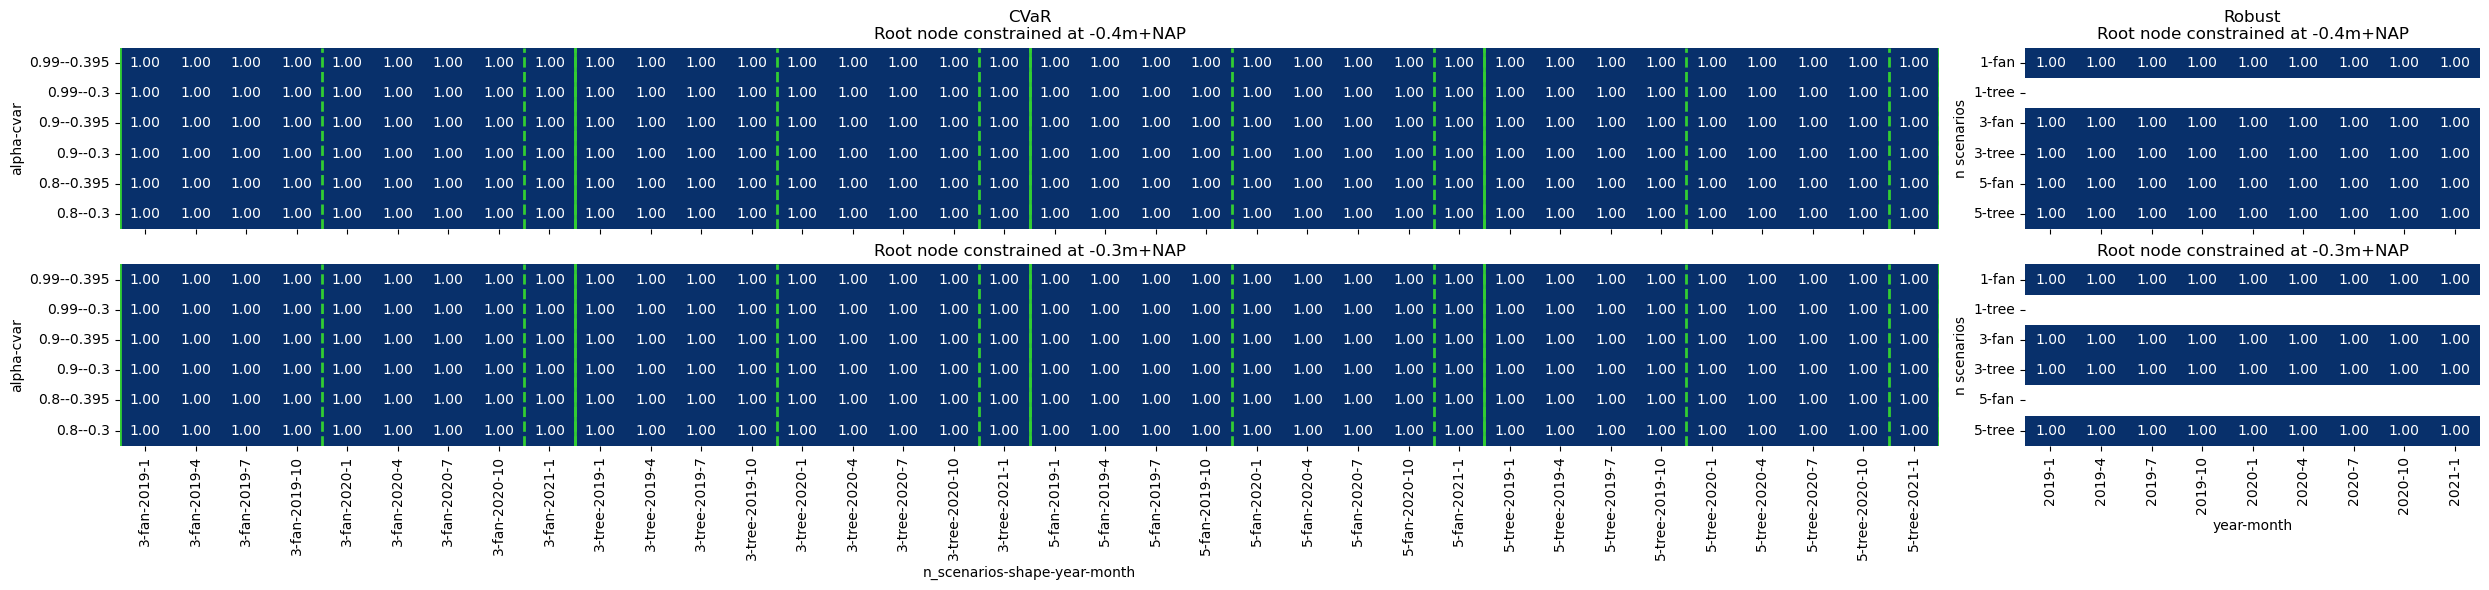

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(25, 6), sharex='col', gridspec_kw={'width_ratios':[4,1]})

sns.heatmap(ts_prog_df_low_cvar, cmap='Blues', vmin=0, vmax=1, annot=True, fmt='.2f', ax=ax[0,0], cbar=False)
ax[0,0].set_title('CVaR\nRoot node constrained at -0.4m+NAP')
ax[0,0].set_xlabel('')
sns.heatmap(ts_prog_df_low_robust, cmap='Blues', vmin=0, vmax=1, annot=True, fmt='.2f', ax=ax[0,1], cbar=False)
ax[0,1].set_title('Robust\nRoot node constrained at -0.4m+NAP')
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('n scenarios')

sns.heatmap(ts_prog_df_high_cvar, cmap='Blues', vmin=0, vmax=1, annot=True, fmt='.2f', ax=ax[1,0], cbar=False)
ax[1,0].set_title('Root node constrained at -0.3m+NAP')
sns.heatmap(ts_prog_df_high_robust, cmap='Blues', vmin=0, vmax=1, annot=True, fmt='.2f', ax=ax[1,1], cbar=False)
ax[1,1].set_title('Root node constrained at -0.3m+NAP')
ax[1,1].set_ylabel('n scenarios')

# Make the lines dividing fans/trees
for i in range(5):
    ax[0,0].axvline(x=9*i, color='limegreen', lw=2)
    ax[1,0].axvline(x=9*i, color='limegreen', lw=2)

# Make the lines dividing the years
for year in [2019, 2020, 2021]:
    if year==2019:
        i0=4
    elif year==2020:
        i0=8
    elif year==2021:
        i0=9

    for i in range(4):
        ax[0,0].axvline(x=i0+i*9, color='limegreen', lw=2, ls='--')
        ax[1,0].axvline(x=i0+i*9, color='limegreen', lw=2, ls='--')

# for i in range(11):
#     ax[0].axvline(x=4+i*4, color='limegreen', lw=2)
#     ax[1].axvline(x=4+i*4, color='limegreen', lw=2)

fig.tight_layout()

In [28]:
def check_done(val):
    # Check for NaN
    if np.isnan(val):
        return True
    # Check for < 1
    if val < 1:
        return True
    else:
        return False


In [29]:
# make the slurm script list for incompleted runs
idx = pd.IndexSlice
cvar_list = [] # entries will be (wl, alpha, cvar, shape, n, year)
robust_list = [] # entries will be (wl, shape, n, year)

for alpha in alphas:
    for cvar in cvars:
        for shape in shapes:
            for n in n_scenarios:
                for year in years:
                    flag_low=False
                    flag_high=False
                    if year != 2021:
                        for month in months:
                            if check_done(ts_prog_df_low_cvar.loc[idx[alpha, cvar], idx[n, shape, year, month]]):
                                flag_low = True
                            if check_done(ts_prog_df_high_cvar.loc[idx[alpha, cvar], idx[n, shape, year, month]]):
                                flag_high = True
                    else:
                        # only one month in 2021
                        month = 1
                        if check_done(ts_prog_df_low_cvar.loc[idx[alpha, cvar], idx[n, shape, year, month]]):
                            flag_low = True
                        if check_done(ts_prog_df_high_cvar.loc[idx[alpha, cvar], idx[n, shape, year, month]]):
                            flag_high = True
                    
                    if flag_low:
                            cvar_list.append((-0.4, alpha, cvar, shape, n, year))
                    if flag_high:
                        cvar_list.append((-0.3, alpha, cvar, shape, n, year))

for shape in shapes:
    n=5 # only 5 scenarios for robust, rest is done
    for year in years:
        flag_low = False
        flag_high = False

        if year != 2021:
            for month in months:
                if check_done(ts_prog_df_low_robust.loc[idx[n, shape], idx[year, month]]):
                    flag_low = True
                if check_done(ts_prog_df_high_robust.loc[idx[n, shape], idx[year, month]]):
                    flag_high = True
        else:
            # only one month in 2021
            month = 1
            if check_done(ts_prog_df_low_robust.loc[idx[n, shape], idx[year, month]]):
                flag_low = True
            if check_done(ts_prog_df_high_robust.loc[idx[n, shape], idx[year, month]]):
                flag_high = True

        if flag_low:
            robust_list.append((-0.4, shape, n, year))
        if flag_high:
            robust_list.append((-0.3, shape, n, year))

In [30]:
ts_cost_df_low_cvar, ts_cost_df_low_robust = ts_cost_df(timeseries_simulation_results, target_indices, -0.4, concat_dfs=False)#, 2019)
ts_cost_df_high_cvar, ts_cost_df_high_robust  = ts_cost_df(timeseries_simulation_results, target_indices, -0.3, concat_dfs=False)#, 2019)

ts_cost_df_low_robust.drop(index=(1,'tree'), inplace=True)
ts_cost_df_high_robust.drop(index=(1,'tree'), inplace=True)

In [31]:
# make cost df nan if the progress isnt 100%
ts_cost_df_low_cvar.where(ts_prog_df_low_cvar == 1, np.nan, inplace=True)
ts_cost_df_low_robust.where(ts_prog_df_low_robust == 1, np.nan, inplace=True)
ts_cost_df_high_cvar.where(ts_prog_df_high_cvar == 1, np.nan, inplace=True)
ts_cost_df_high_robust.where(ts_prog_df_high_robust == 1, np.nan, inplace=True)

In [32]:
ts_cost_yearly_df_low_cvar, ts_cost_yearly_df_low_robust = ts_yearly_cost_df(timeseries_simulation_results, target_indices, -0.4, concat_dfs=False)#, 2019)
ts_cost_yearly_df_high_cvar, ts_cost_yearly_df_high_robust  = ts_yearly_cost_df(timeseries_simulation_results, target_indices, -0.3, concat_dfs=False)#, 2019)

ts_cost_yearly_df_low_robust.drop(index=(1,'tree'), inplace=True)
ts_cost_yearly_df_high_robust.drop(index=(1,'tree'), inplace=True)

In [33]:
for y in [2019, 2020, 2021]:
    for month in [1, 4, 7, 10]:
        print(y, month, len(timeseries_simulation_results[-0.4]['robust']['fan'][3][y][month].df.dropna()))

2019 1 719
2019 4 631
2019 7 574
2019 10 408
2020 1 713
2020 4 686
2020 7 712
2020 10 567
2021 1 680
2021 4 1
2021 7 1
2021 10 1


In [34]:
for y in [2019, 2020, 2021]:
    for month in [1, 4, 7, 10]:
        print(y, month, len(timeseries_simulation_results[-0.4][0.99][-0.395]['tree'][5][y][month].df.dropna()))

2019 1 719
2019 4 631
2019 7 574
2019 10 408
2020 1 713
2020 4 686
2020 7 712
2020 10 567
2021 1 680
2021 4 1
2021 7 1
2021 10 1


In [35]:
import matplotlib

In [36]:
norm = matplotlib.colors.Normalize(-2,2)
colors = [[norm(2), "azure"],
          [norm(0), "deepskyblue"],
          [norm(0.01), "lightcoral"],
          [norm(0.0999), "firebrick"],
          [norm(0.1), "black"]]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)


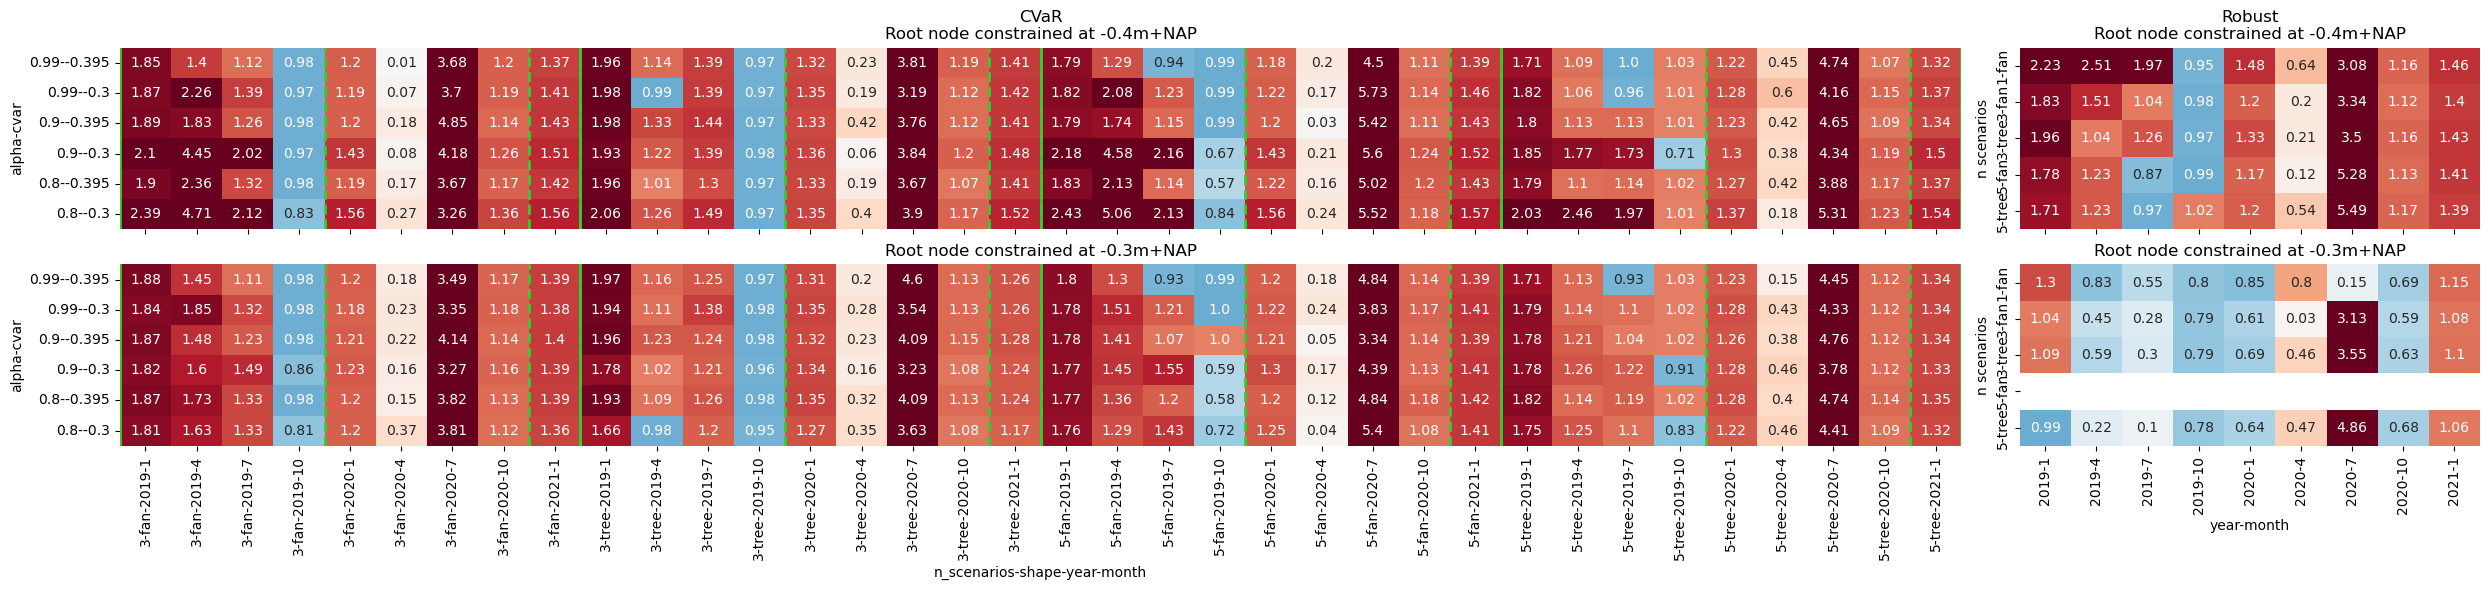

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(25, 6), sharex='col', gridspec_kw={'width_ratios':[4,1]})
sns.heatmap(ts_cost_df_low_cvar, cmap='RdBu_r', vmin=-2, vmax=2, annot=True, fmt='.2f', ax=ax[0,0], cbar=False)
ax[0,0].set_title('CVaR\nRoot node constrained at -0.4m+NAP')
ax[0,0].set_xlabel('')
sns.heatmap(ts_cost_df_low_robust, cmap='RdBu_r', vmin=-2, vmax=2, annot=True, fmt='.2f', ax=ax[0,1], cbar=False)
ax[0,1].set_title('Robust\nRoot node constrained at -0.4m+NAP')
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('n scenarios')

sns.heatmap(ts_cost_df_high_cvar, cmap='RdBu_r', vmin=-2, vmax=2, annot=True, fmt='.2f', ax=ax[1,0], cbar=False)
ax[1,0].set_title('Root node constrained at -0.3m+NAP')
sns.heatmap(ts_cost_df_high_robust, cmap='RdBu_r', vmin=-2, vmax=2, annot=True, fmt='.2f', ax=ax[1,1], cbar=False)
ax[1,1].set_title('Root node constrained at -0.3m+NAP')
ax[1,1].set_ylabel('n scenarios')

# Make the lines dividing fans/trees
for i in range(5):
    ax[0,0].axvline(x=9*i, color='limegreen', lw=2)
    ax[1,0].axvline(x=9*i, color='limegreen', lw=2)

# Make the lines dividing the years
for year in [2019, 2020, 2021]:
    if year==2019:
        i0=4
    elif year==2020:
        i0=8
    elif year==2021:
        i0=9

    for i in range(4):
        ax[0,0].axvline(x=i0+i*9, color='limegreen', lw=2, ls='--')
        ax[1,0].axvline(x=i0+i*9, color='limegreen', lw=2, ls='--')

# Now display all annotations in absolute value
for i in range(2):
    for j in range(2):
        for text in ax[i,j].texts:
            text.set_text(abs(float(text.get_text())))
fig.tight_layout()

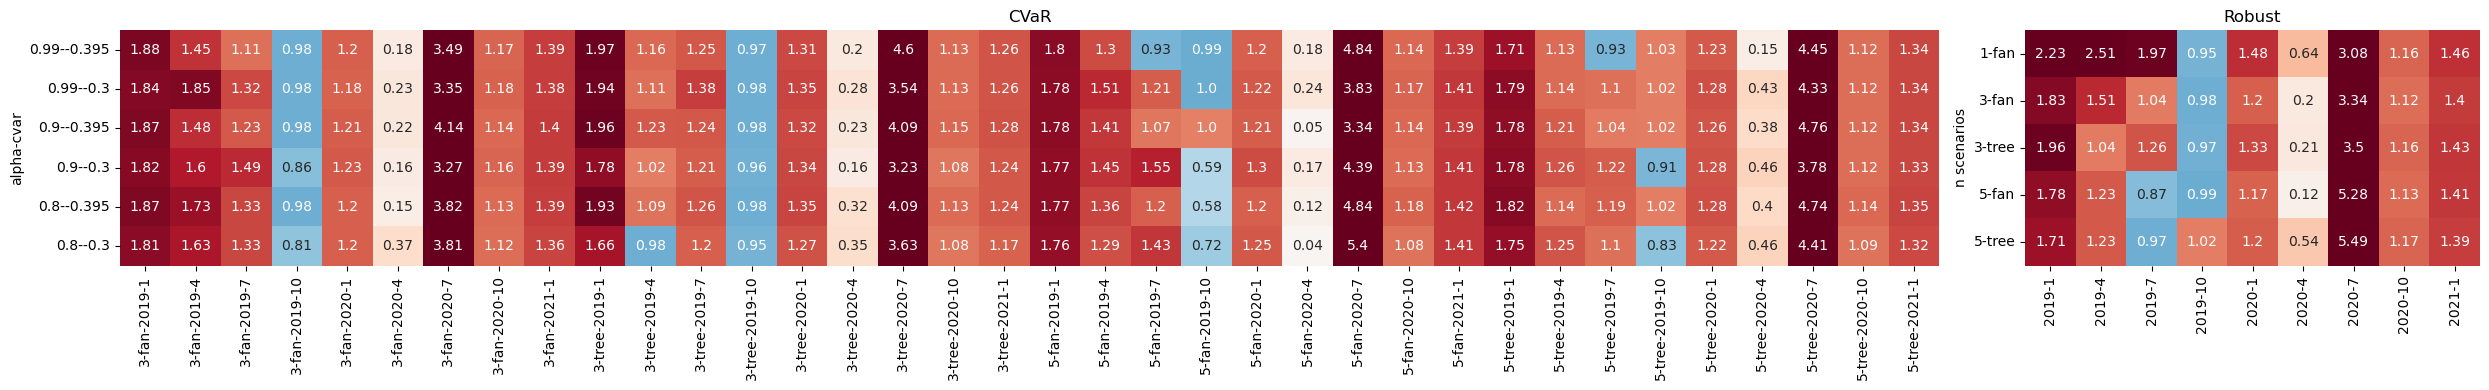

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(25, 4), sharex='col', gridspec_kw={'width_ratios':[4,1]})
sns.heatmap(ts_cost_df_high_cvar, cmap='RdBu_r', vmin=-2, vmax=2, annot=True, fmt='.2f', ax=ax[0], cbar=False)
ax[0].set_title('CVaR')
ax[0].set_xlabel('')

sns.heatmap(ts_cost_df_low_robust, cmap='RdBu_r', vmin=-2, vmax=2, annot=True, fmt='.2f', ax=ax[1], cbar=False)
ax[1].set_title('Robust')
ax[1].set_xlabel('')
ax[1].set_ylabel('n scenarios')
ax[1].set_yticklabels(ax[1].get_yticklabels(), rotation=0)

# Now display all annotations in absolute value
for i in range(2):
    for text in ax[i].texts:
        text.set_text(abs(float(text.get_text())))

fig.tight_layout()

In [39]:
ts_cost_yearly_df_low_robust

year                   2019      2020      2021
n_scenarios shape                              
1           fan    1.414790  1.423564  1.460806
3           fan    1.222016  1.319665  1.403504
            tree   1.254953  1.409906  1.429145
5           fan    1.194979  1.406435  1.411511
            tree   1.202185  1.418991  1.388113

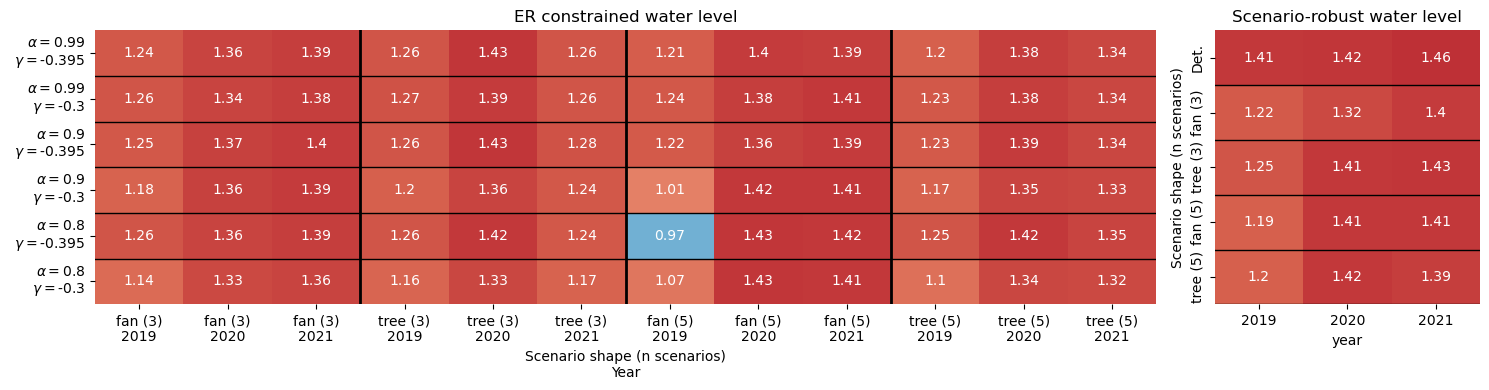

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharex='col', gridspec_kw={'width_ratios':[4,1]})
sns.heatmap(ts_cost_yearly_df_high_cvar, cmap='RdBu_r', vmin=-2, vmax=2, annot=True, fmt='.2f', ax=ax[0], cbar=False)
ax[0].set_title('ER constrained water level')


sns.heatmap(ts_cost_yearly_df_low_robust, cmap='RdBu_r', vmin=-2, vmax=2, annot=True, fmt='.2f', ax=ax[1], cbar=False)
ax[1].set_title('Scenario-robust water level')
ax[1].set_ylabel('Scenario shape (n scenarios)')
ax[0].set_ylabel('')
ax[0].set_xlabel('Scenario shape (n scenarios)\nYear')

# Now display all annotations in absolute value
for i in range(2):
    for text in ax[i].texts:
        text.set_text(abs(float(text.get_text())))

ax[0].set_yticklabels([r"$\alpha=$"+f"{l.get_text().split('-')[0]}\n "+r"$\gamma=$"+f"-{l.get_text().split('-')[-1]}" for l in ax[0].get_yticklabels()])
ax[0].set_xticklabels([f"{l.get_text().split('-')[1]} ({l.get_text().split('-')[0]})\n{l.get_text().split('-')[2]}" for l in ax[0].get_xticklabels()], rotation=0)
y1ticklabels = [f"{l.get_text().split('-')[1]} ({l.get_text().split('-')[0]})" for l in ax[1].get_yticklabels()]
y1ticklabels[0] = 'Det.'
ax[1].set_yticklabels(y1ticklabels)

# now make a vertical line seperating the scenario shapes
for i in range(3):
    ax[0].axvline(x=3+i*3, color='k', lw=2)
    # ax[1].axvline(x=4+i*4, color='limegreen', lw=2)

# now make a horizontal line seperating the cvar settings
for i in range(5):
    ax[0].axhline(y=i+1, color='k', lw=1)
    ax[1].axhline(y=i+1, color='k', lw=1)
    
fig.tight_layout()
fig.savefig('yearly_cost.pdf', bbox_inches='tight')

In [119]:
ts_cost_yearly_df_high_cvar

n_scenarios          3                                                    \
shape              fan                          tree                       
year              2019      2020      2021      2019      2020      2021   
alpha cvar                                                                 
0.99  -0.395  1.239795  1.358588  1.389036  1.262223  1.430829  1.256952   
      -0.300  1.256834  1.344272  1.384405  1.268676  1.391909  1.255680   
0.90  -0.395  1.247584  1.374183  1.401392  1.264169  1.425166  1.279438   
      -0.300  1.183042  1.360384  1.393431  1.200145  1.356154  1.240425   
0.80  -0.395  1.263357  1.356155  1.389902  1.256987  1.416070  1.241484   
      -0.300  1.137852  1.327641  1.356989  1.158686  1.329437  1.172615   

n_scenarios          5                                                    
shape              fan                          tree                      
year              2019      2020      2021      2019      2020      2021  
alpha cvar                                                                
0.99  -0.395  1.208449  1.402879  1.386505  1.200142  1.384438  1.341297  
      -0.300  1.235359  1.377897  1.414643  1.234945  1.383149  1.339994  
0.90  -0.395  1.223499  1.360336  1.391853  1.226971  1.391447  1.335642  
      -0.300  1.008529  1.421061  1.411052  1.173201  1.351608  1.334741  
0.80  -0.395 -0.966331  1.427414  1.415002  1.251671  1.417055  1.349284  
      -0.300  1.070513  1.426941  1.410769  1.104240  1.339499  1.318719

In [132]:
ts_cost_yearly_df_high_robust

year                   2019      2020      2021
n_scenarios shape                              
1           fan   -0.908832 -0.731643  1.145419
3           fan   -0.802616 -0.751829  1.080439
            tree  -0.823722 -0.796875  1.101852
5           fan   -0.000000 -0.000000 -0.000000
            tree  -0.759287 -0.855115  1.059282

In [152]:
delta_rob_df = ts_cost_yearly_df_high_cvar.abs().copy()
delta_det_df = ts_cost_yearly_df_high_cvar.abs().copy()
delta_tree_df = ts_cost_yearly_df_high_cvar.abs().copy()

for n in n_scenarios:
    for shape in shapes:
        for year in years:
            delta_rob_df.loc[:, idx[n, shape, year]] -= ts_cost_yearly_df_low_robust.loc[idx[n, shape], year].values[0]
            delta_det_df.loc[:, idx[n, shape, year]] -= ts_cost_yearly_df_low_robust.loc[(1, 'fan'), year].values[0]
            
            if shape == 'fan':
                delta_tree_df.loc[:, idx[n, 'fan', year]] -= ts_cost_yearly_df_high_cvar.loc[:, idx[n, 'tree', year]]
            else:
                delta_tree_df.loc[:, idx[n, 'tree', year]] = np.nan

In [151]:
delta_rob_df.mean().mean()

-0.032770054787477694

Text(0.5, 1.0, 'Relative CVaR cost - relative robust cost')

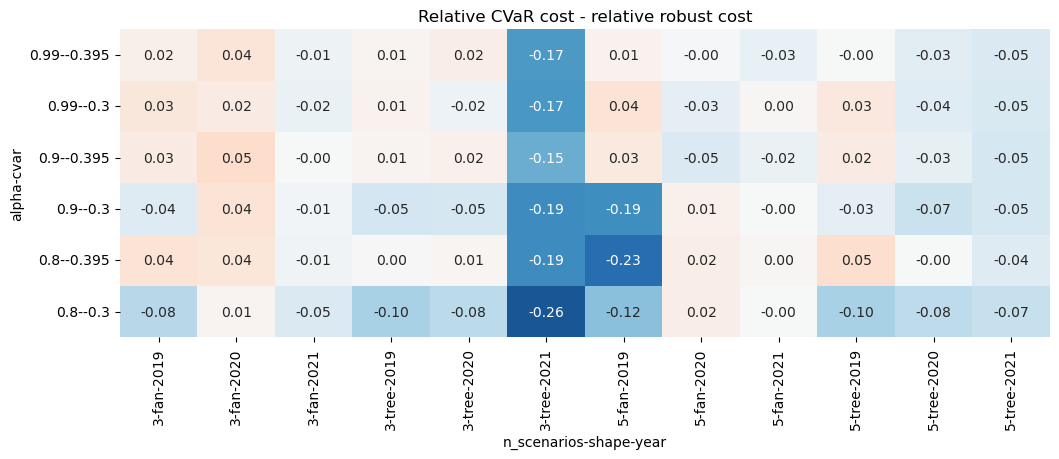

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.heatmap(delta_rob_df, cmap='RdBu_r', vmin=-0.3, vmax=0.3, annot=True, fmt='.2f', ax=ax, cbar=False)
ax.set_title(r'Relative CVaR cost - relative robust cost')

Text(0.5, 1.0, 'Relative CVaR cost - relative deterministic cost')

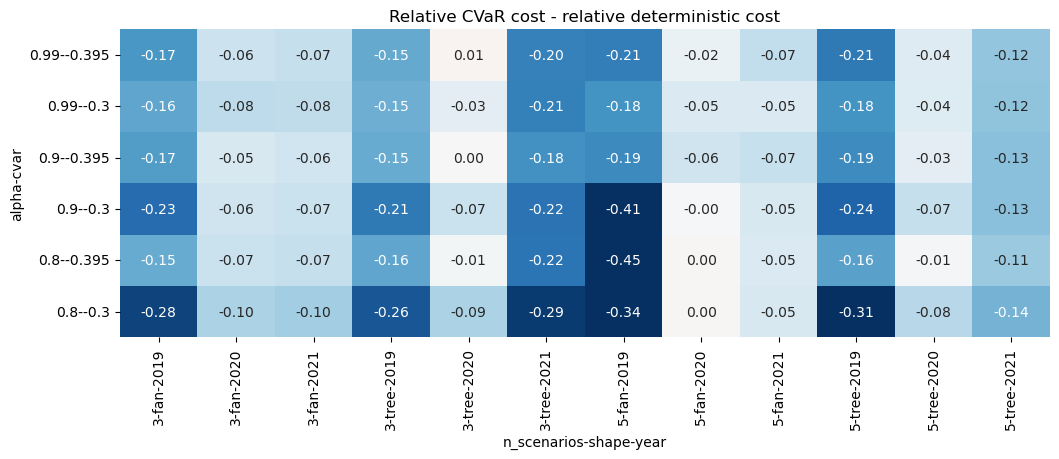

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.heatmap(delta_det_df, cmap='RdBu_r', vmin=-0.3, vmax=0.3, annot=True, fmt='.2f', ax=ax, cbar=False)
ax.set_title(r'Relative CVaR cost - relative deterministic cost')

Text(0.5, 1.0, 'Relative CVaR cost - relative deterministic cost')

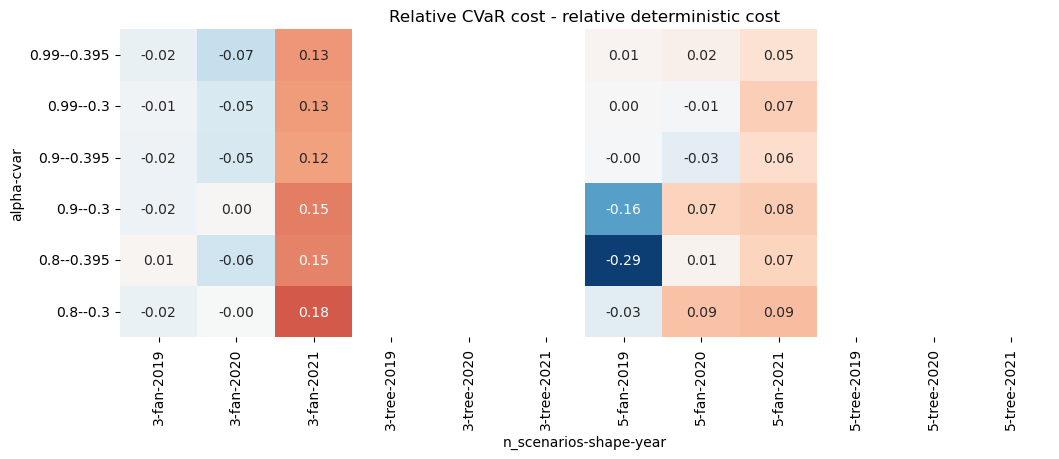

In [153]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.heatmap(delta_tree_df, cmap='RdBu_r', vmin=-0.3, vmax=0.3, annot=True, fmt='.2f', ax=ax, cbar=False)
ax.set_title(r'Relative CVaR cost - relative deterministic cost')

In [67]:
ts_cost_yearly_df_high_cvar

n_scenarios          3                                                    \
shape              fan                          tree                       
year              2019      2020      2021      2019      2020      2021   
alpha cvar                                                                 
0.99  -0.395  1.239795  1.358588  1.389036  1.262223  1.430829  1.256952   
      -0.300  1.256834  1.344272  1.384405  1.268676  1.391909  1.255680   
0.90  -0.395  1.247584  1.374183  1.401392  1.264169  1.425166  1.279438   
      -0.300  1.183042  1.360384  1.393431  1.200145  1.356154  1.240425   
0.80  -0.395  1.263357  1.356155  1.389902  1.256987  1.416070  1.241484   
      -0.300  1.137852  1.327641  1.356989  1.158686  1.329437  1.172615   

n_scenarios          5                                                    
shape              fan                          tree                      
year              2019      2020      2021      2019      2020      2021  
alpha cvar                                                                
0.99  -0.395  1.208449  1.402879  1.386505  1.200142  1.384438  1.341297  
      -0.300  1.235359  1.377897  1.414643  1.234945  1.383149  1.339994  
0.90  -0.395  1.223499  1.360336  1.391853  1.226971  1.391447  1.335642  
      -0.300  1.008529  1.421061  1.411052  1.173201  1.351608  1.334741  
0.80  -0.395 -0.966331  1.427414  1.415002  1.251671  1.417055  1.349284  
      -0.300  1.070513  1.426941  1.410769  1.104240  1.339499  1.318719

In [68]:
ts_cost_yearly_df_low_cvar.where(ts_cost_yearly_df_low_cvar != 0, np.nan, inplace=True)
ts_cost_yearly_df_low_robust.where(ts_cost_yearly_df_low_robust != 0, np.nan, inplace=True)
ts_cost_yearly_df_high_cvar.where(ts_cost_yearly_df_high_cvar != 0, np.nan, inplace=True)
ts_cost_yearly_df_high_robust.where(ts_cost_yearly_df_high_robust != 0, np.nan, inplace=True)

In [69]:
makenan_cvar = {}
makenan_robust = {}

for alpha in alphas:
    makenan_cvar[alpha] = {}
    for cvar in cvars:
        makenan_cvar[alpha][cvar] = {}
        for shape in shapes:
            makenan_cvar[alpha][cvar][shape] = {}
            for n in n_scenarios:
                makenan_cvar[alpha][cvar][shape][n] = {}
                for year in years:
                    makenan_cvar[alpha][cvar][shape][n][year] = {'cvar_low':False, 'cvar_high':False}

for row in ts_cost_df_low_cvar.index:
    for col in ts_cost_df_low_cvar.columns:
        alpha = row[0]
        cvar = row[1]
        shape = col[1]
        n = col[0]
        year = col[2]
        month = col[3]
        if np.isnan(ts_cost_df_low_cvar.loc[row, col]):
            makenan_cvar[alpha][cvar][shape][n][year]['cvar_low'] = True
        if np.isnan(ts_cost_df_high_cvar.loc[row, col]):
            makenan_cvar[alpha][cvar][shape][n][year]['cvar_high'] = True

for shape in shapes:
    makenan_robust[shape] = {}
    for n in [1, 3, 5]:
        makenan_robust[shape][n] = {}
        for year in years:
            makenan_robust[shape][n][year] = {'robust_low':False, 'robust_high':False}
        
for row in ts_cost_df_low_robust.index:
    for col in ts_cost_df_low_robust.columns:
        shape = row[1]
        n = row[0]
        year = col[0]
        month = col[1]
        if np.isnan(ts_cost_df_low_robust.loc[row, col]):
            makenan_robust[shape][n][year]['robust_low'] = True
        if np.isnan(ts_cost_df_high_robust.loc[row, col]):
            makenan_robust[shape][n][year]['robust_high'] = True

for row in ts_cost_yearly_df_high_cvar.index:
    for col in ts_cost_yearly_df_high_cvar.columns:
        alpha = row[0]
        cvar = row[1]
        shape = col[1]
        n = col[0]
        year = col[2]
        if makenan_cvar[alpha][cvar][shape][n][year]['cvar_high']:
            ts_cost_yearly_df_high_cvar.loc[row, col] = np.nan
        if makenan_cvar[alpha][cvar][shape][n][year]['cvar_low']:
            ts_cost_yearly_df_low_cvar.loc[row, col] = np.nan

for row in ts_cost_yearly_df_high_robust.index:
    for col in ts_cost_yearly_df_high_robust.columns:
        shape = row[1]
        n = row[0]
        year = col[0]
        if makenan_robust[shape][n][year]['robust_high']:
            ts_cost_yearly_df_high_robust.loc[row, col] = np.nan
        if makenan_robust[shape][n][year]['robust_low']:
            ts_cost_yearly_df_low_robust.loc[row, col] = np.nan
            

                #     flag_low_cvar = False
                #     flag_high_cvar = False
                #     flag_low_robust = False
                #     flag_high_robust = False
                #     for month in months:
                #         try:
                #             if np.isnan(ts_cost_df_low_cvar.loc[idx[alpha, cvar], idx[n, shape, year, month]]):
                #                 flag_low_cvar = True
                #         except KeyError:
                #             pass
                #         try:
                #             if np.isnan(ts_cost_df_high_cvar.loc[idx[alpha, cvar], idx[n, shape, year, month]]):
                #                 flag_high_cvar = True
                #         except KeyError:
                #             pass
                #         try:
                #             if np.isnan(ts_cost_df_low_robust.loc[idx[n, shape], idx[year, month]]):
                #                 flag_low_robust = True
                #         except KeyError:
                #             pass
                #         try:
                #             if np.isnan(ts_cost_df_high_robust.loc[idx[n, shape], idx[year, month]]):
                #                 flag_high_robust = True
                #         except KeyError:
                #             pass
                # if flag_low_cvar:
                #     ts_cost_yearly_df_low_cvar.loc[idx[alpha, cvar], idx[n, shape, year]] = np.nan
                # if flag_high_cvar:
                #     ts_cost_yearly_df_high_cvar.loc[idx[alpha, cvar], idx[n, shape, year]] = np.nan
                # if flag_low_robust:
                #     ts_cost_yearly_df_low_robust.loc[idx[n, shape], idx[year]] = np.nan
                # if flag_high_robust:
                #     ts_cost_yearly_df_high_robust.loc[idx[n, shape], idx[year]] = np.nan
                    



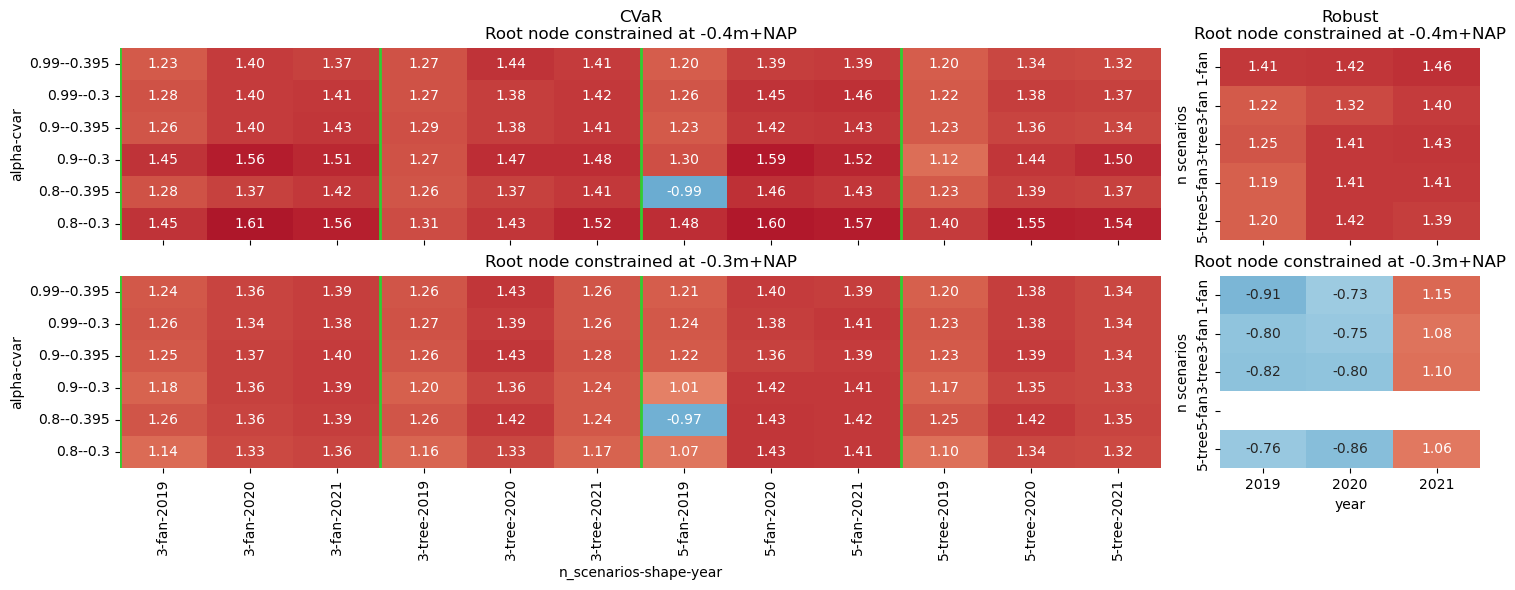

In [70]:
fig, ax = plt.subplots(2, 2, figsize=(15, 6), sharex='col', gridspec_kw={'width_ratios':[4,1]})
sns.heatmap(ts_cost_yearly_df_low_cvar, cmap='RdBu_r', vmin=-2, vmax=2, annot=True, fmt='.2f', ax=ax[0,0], cbar=False)
ax[0,0].set_title('CVaR\nRoot node constrained at -0.4m+NAP')
ax[0,0].set_xlabel('')
sns.heatmap(ts_cost_yearly_df_low_robust, cmap='RdBu_r', vmin=-2, vmax=2, annot=True, fmt='.2f', ax=ax[0,1], cbar=False)
ax[0,1].set_title('Robust\nRoot node constrained at -0.4m+NAP')
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('n scenarios')

sns.heatmap(ts_cost_yearly_df_high_cvar, cmap='RdBu_r', vmin=-2, vmax=2, annot=True, fmt='.2f', ax=ax[1,0], cbar=False)
ax[1,0].set_title('Root node constrained at -0.3m+NAP')
sns.heatmap(ts_cost_yearly_df_high_robust, cmap='RdBu_r', vmin=-2, vmax=2, annot=True, fmt='.2f', ax=ax[1,1], cbar=False)
ax[1,1].set_title('Root node constrained at -0.3m+NAP')
ax[1,1].set_ylabel('n scenarios')

# Make the lines dividing fans/trees
for i in range(4):
    ax[0,0].axvline(x=3*i, color='limegreen', lw=2)
    ax[1,0].axvline(x=3*i, color='limegreen', lw=2)

fig.tight_layout()

In [71]:
# ts_da_perc_df_low = ts_da_percentage_df(timeseries_simulation_results, target_indices, -0.4)
# ts_da_perc_df_high = ts_da_percentage_df(timeseries_simulation_results, target_indices, -0.3)

In [72]:
ts_da_perc_df_low_cvar, ts_da_perc_df_low_robust = ts_da_percentage_df(timeseries_simulation_results, target_indices, -0.4, concat_dfs=False)
ts_da_perc_df_high_cvar, ts_da_perc_df_high_robust  = ts_da_percentage_df(timeseries_simulation_results, target_indices, -0.3, concat_dfs=False)

In [73]:
ts_da_perc_df_low_robust

year                   2019                                    2020            \
month                    1         4         7         10        1         4    
n_scenarios shape                                                               
1           fan    0.173831  0.178476  0.140103  0.550326  0.233826  0.015126   
            tree        NaN       NaN       NaN       NaN       NaN       NaN   
3           fan    0.222898  0.255492  0.134529  0.481278  0.322398  0.000037   
            tree   0.224374  0.272090  0.085787  0.499162  0.239587  0.000000   
5           fan    0.231060  0.214744  0.191104  0.505229  0.293885  0.005078   
            tree   0.194842  0.301082  0.131664  0.542160  0.265493  0.000000   

year                                       2021  
month                    7         10        1   
n_scenarios shape                                
1           fan    0.107689  0.287974  0.402506  
            tree        NaN       NaN       NaN  
3           fan    0.050098  0.228133  0.410252  
            tree   0.047333  0.279327  0.425187  
5           fan    0.011783  0.228755  0.428487  
            tree   0.004585  0.217552  0.456207

In [74]:
timeseries_simulation_results[-0.4]['robust']['fan'][3][2019][1].get_day_ahead_percentage(index=target_indices[2019][1])

0.22289832254437716

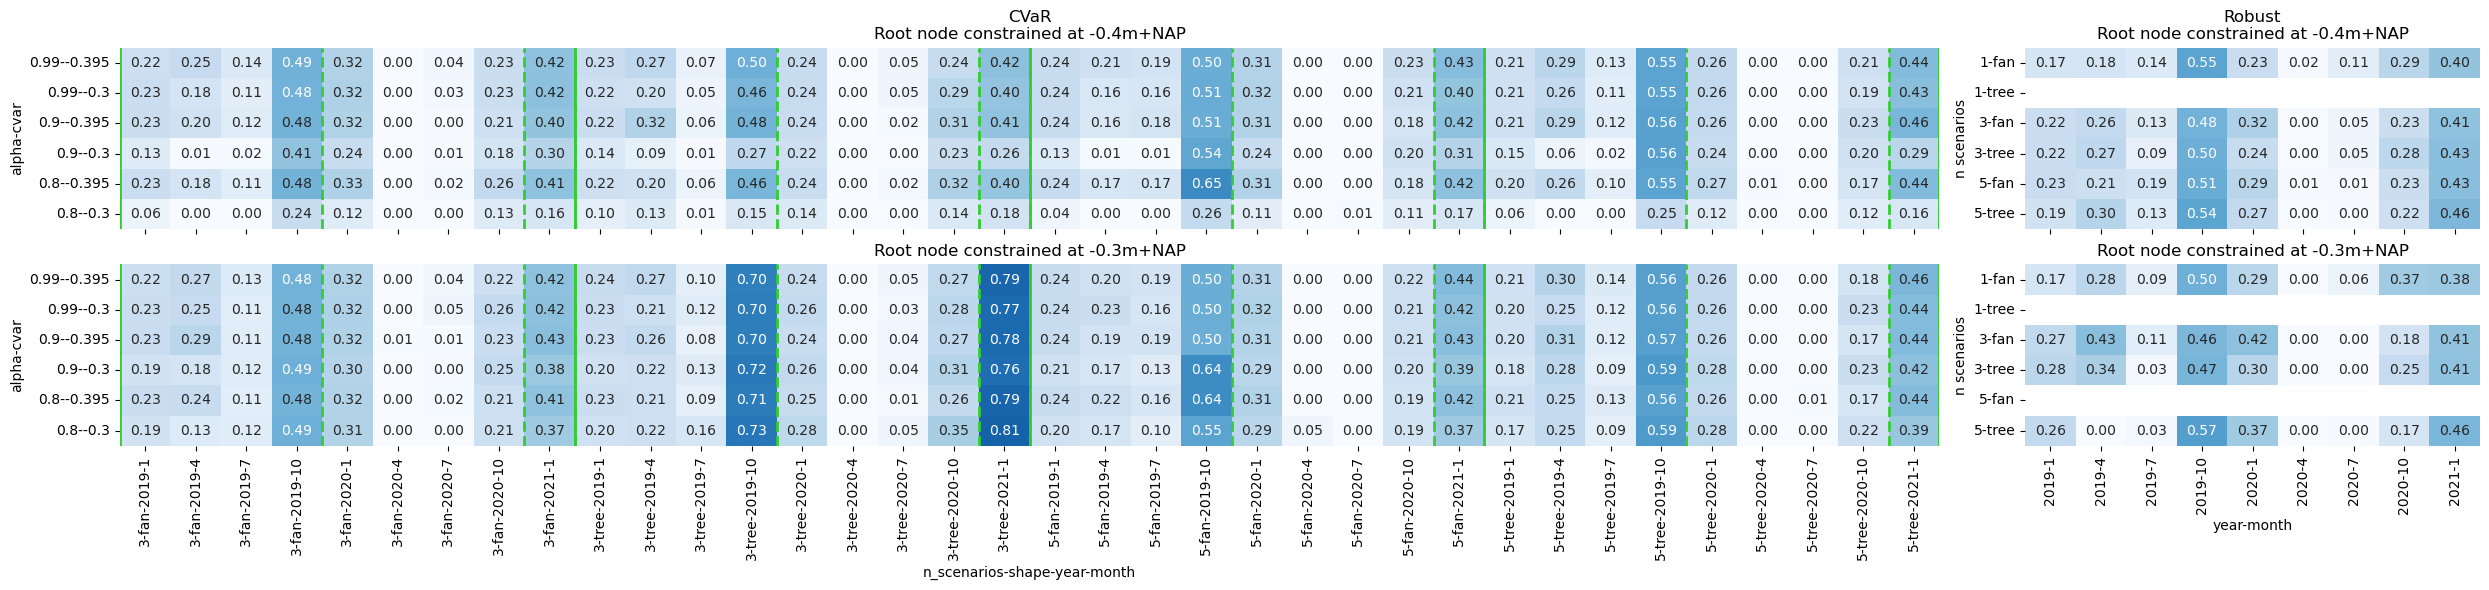

In [75]:
fig, ax = plt.subplots(2, 2, figsize=(25, 6), sharex='col', gridspec_kw={'width_ratios':[4,1]})
sns.heatmap(ts_da_perc_df_low_cvar, cmap='Blues', vmin=0, vmax=1, annot=True, fmt='.2f', ax=ax[0,0], cbar=False)
ax[0,0].set_title('CVaR\nRoot node constrained at -0.4m+NAP')
ax[0,0].set_xlabel('')
sns.heatmap(ts_da_perc_df_low_robust, cmap='Blues', vmin=0, vmax=1, annot=True, fmt='.2f', ax=ax[0,1], cbar=False)
ax[0,1].set_title('Robust\nRoot node constrained at -0.4m+NAP')
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('n scenarios')

sns.heatmap(ts_da_perc_df_high_cvar, cmap='Blues', vmin=0, vmax=1, annot=True, fmt='.2f', ax=ax[1,0], cbar=False)
ax[1,0].set_title('Root node constrained at -0.3m+NAP')
sns.heatmap(ts_da_perc_df_high_robust, cmap='Blues', vmin=0, vmax=1, annot=True, fmt='.2f', ax=ax[1,1], cbar=False)
ax[1,1].set_title('Root node constrained at -0.3m+NAP')
ax[1,1].set_ylabel('n scenarios')

# Make the lines dividing fans/trees
for i in range(5):
    ax[0,0].axvline(x=9*i, color='limegreen', lw=2)
    ax[1,0].axvline(x=9*i, color='limegreen', lw=2)

# Make the lines dividing the years
for year in [2019, 2020, 2021]:
    if year==2019:
        i0=4
    elif year==2020:
        i0=8
    elif year==2021:
        i0=9

    for i in range(4):
        ax[0,0].axvline(x=i0+i*9, color='limegreen', lw=2, ls='--')
        ax[1,0].axvline(x=i0+i*9, color='limegreen', lw=2, ls='--')

fig.tight_layout()

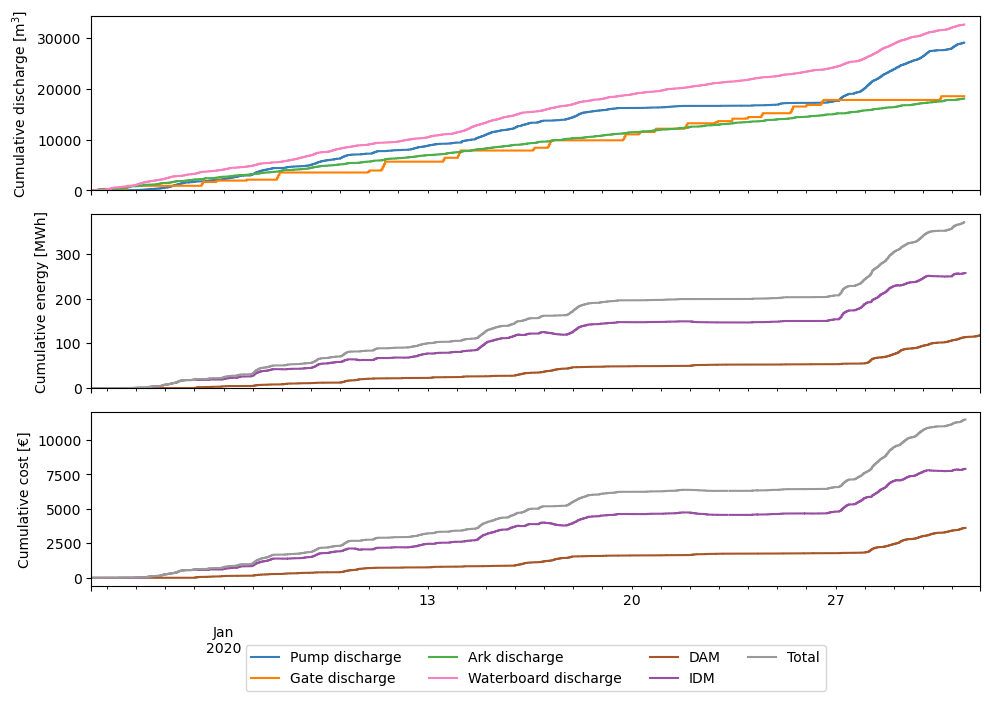

In [76]:
timeseries_simulation_results[-0.3][0.99][-0.395]['fan'][5][2020][1].plot_cumulatives()

In [77]:
# ts_avg_cost_df_low = ts_avg_energy_cost_df(timeseries_simulation_results, target_indices, -0.4)
# ts_avg_cost_df_high = ts_avg_energy_cost_df(timeseries_simulation_results, target_indices, -0.3)

In [78]:
ts_avg_cost_df_low_cvar, ts_avg_cost_df_low_robust = ts_avg_energy_cost_df(timeseries_simulation_results, target_indices, -0.4, concat_dfs=False)
ts_avg_cost_df_high_cvar, ts_avg_cost_df_high_robust  = ts_avg_energy_cost_df(timeseries_simulation_results, target_indices, -0.3, concat_dfs=False)

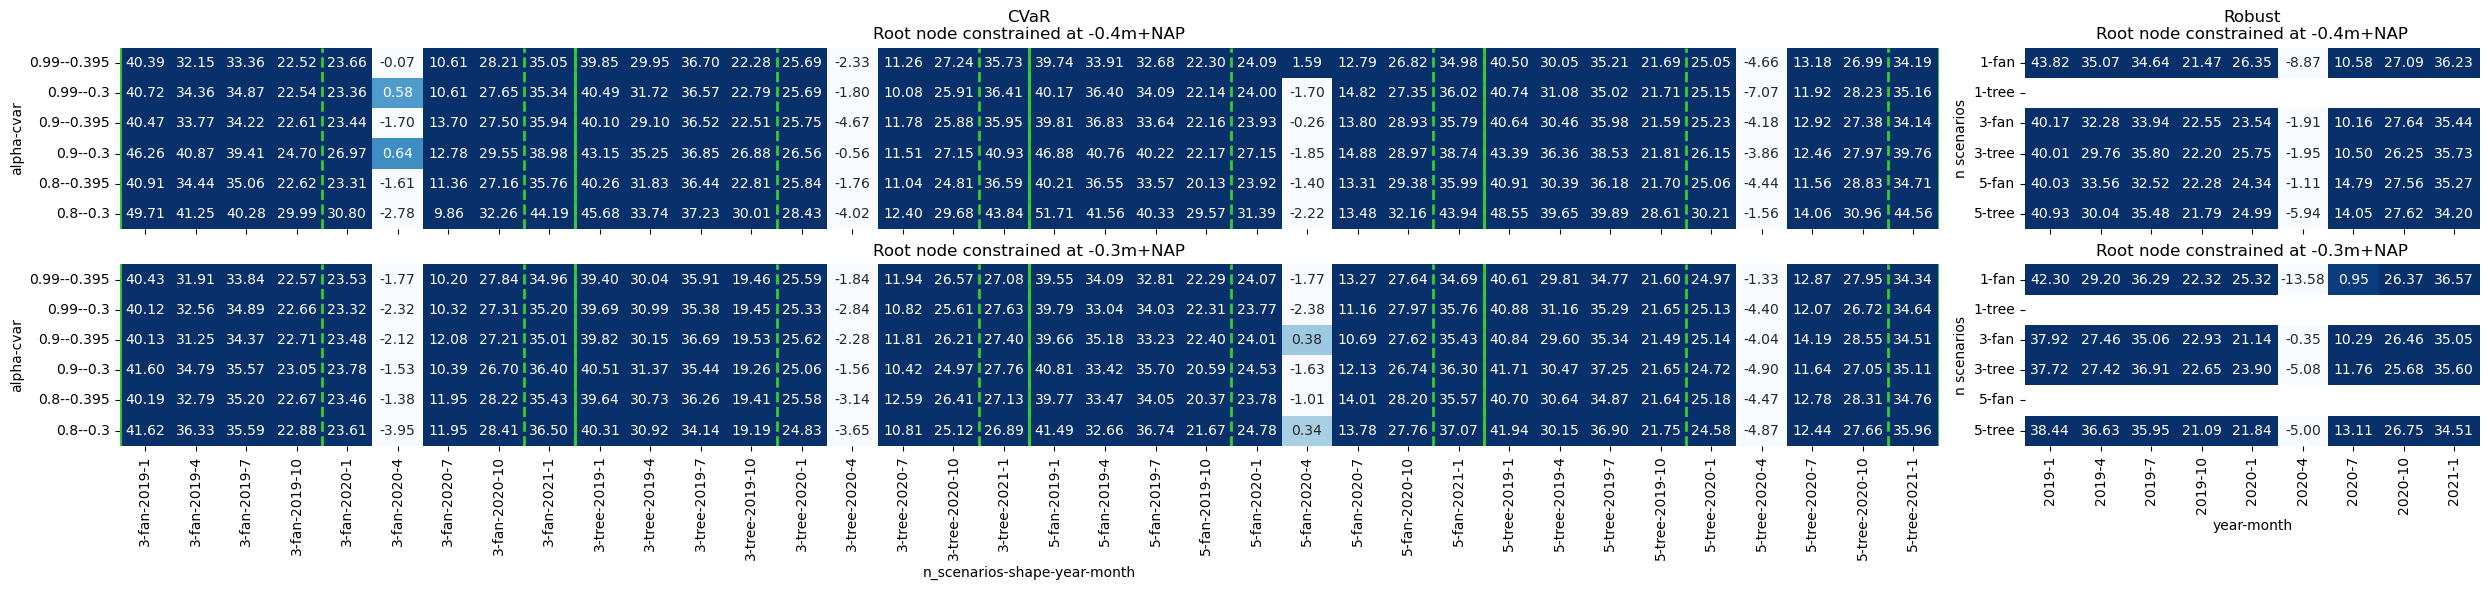

In [79]:
fig, ax = plt.subplots(2, 2, figsize=(25, 6), sharex='col', gridspec_kw={'width_ratios':[4,1]})
sns.heatmap(ts_avg_cost_df_low_cvar, cmap='Blues', vmin=0, vmax=1, annot=True, fmt='.2f', ax=ax[0,0], cbar=False)
ax[0,0].set_title('CVaR\nRoot node constrained at -0.4m+NAP')
ax[0,0].set_xlabel('')
sns.heatmap(ts_avg_cost_df_low_robust, cmap='Blues', vmin=0, vmax=1, annot=True, fmt='.2f', ax=ax[0,1], cbar=False)
ax[0,1].set_title('Robust\nRoot node constrained at -0.4m+NAP')
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('n scenarios')

sns.heatmap(ts_avg_cost_df_high_cvar, cmap='Blues', vmin=0, vmax=1, annot=True, fmt='.2f', ax=ax[1,0], cbar=False)
ax[1,0].set_title('Root node constrained at -0.3m+NAP')
sns.heatmap(ts_avg_cost_df_high_robust, cmap='Blues', vmin=0, vmax=1, annot=True, fmt='.2f', ax=ax[1,1], cbar=False)
ax[1,1].set_title('Root node constrained at -0.3m+NAP')
ax[1,1].set_ylabel('n scenarios')

# Make the lines dividing fans/trees
for i in range(5):
    ax[0,0].axvline(x=9*i, color='limegreen', lw=2)
    ax[1,0].axvline(x=9*i, color='limegreen', lw=2)

# Make the lines dividing the years
for year in [2019, 2020, 2021]:
    if year==2019:
        i0=4
    elif year==2020:
        i0=8
    elif year==2021:
        i0=9

    for i in range(4):
        ax[0,0].axvline(x=i0+i*9, color='limegreen', lw=2, ls='--')
        ax[1,0].axvline(x=i0+i*9, color='limegreen', lw=2, ls='--')

fig.tight_layout()

In [80]:
# fig, ax = plt.subplots(2, 1, figsize=(25, 6), sharex=True)

# sns.heatmap(ts_prog_df_low, cmap='Blues', vmin=0, vmax=1, annot=True, fmt='.2f', ax=ax[0], cbar=False)
# ax[0].set_title('Root node constrained at -0.4m+NAP')

# sns.heatmap(ts_prog_df_high, cmap='Blues', vmin=0, vmax=1, annot=True, fmt='.2f', ax=ax[1], cbar=False)
# ax[1].set_title('Root node constrained at -0.3m+NAP')

# # Make the lines dividing fans/trees
# for i in range(5):
#     ax[0].axvline(x=9*i, color='limegreen', lw=2)
#     ax[1].axvline(x=9*i, color='limegreen', lw=2)

# # Make the lines dividing the years
# for year in [2019, 2020, 2021]:
#     if year==2019:
#         i0=4
#     elif year==2020:
#         i0=8
#     elif year==2021:
#         i0=9

#     for i in range(4):
#         ax[0].axvline(x=i0+i*9, color='limegreen', lw=2, ls='--')
#         ax[1].axvline(x=i0+i*9, color='limegreen', lw=2, ls='--')

# # for i in range(11):
# #     ax[0].axvline(x=4+i*4, color='limegreen', lw=2)
# #     ax[1].axvline(x=4+i*4, color='limegreen', lw=2)

# fig.tight_layout()

NameError: name 'ts_cost_df_low' is not defined

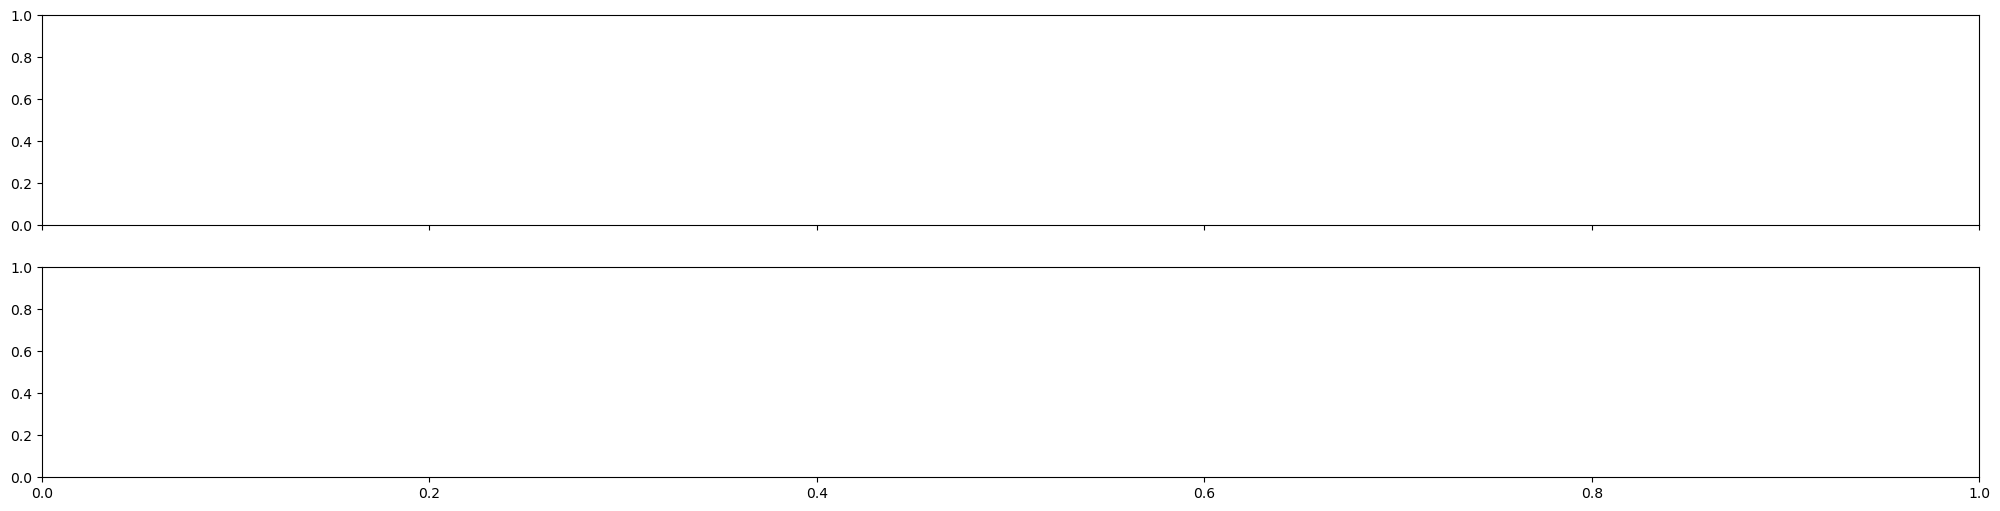

In [81]:
fig, ax = plt.subplots(2, 1, figsize=(25, 6), sharex=True)
max_cost = 3#max(ts_cost_df_low.max().max(), ts_cost_df_high.max().max())
rounded_max_cost = 3#np.ceil(max_cost / 1000) * 1000 / 5
sns.heatmap(ts_cost_df_low, cmap='RdBu', vmin=-3, vmax=3, annot=True, fmt='.3f', ax=ax[0], cbar=False)
ax[0].set_title('Root node constrained at -0.4m+NAP')

sns.heatmap(ts_cost_df_high, cmap='RdBu', vmin=-3, vmax=3, annot=True, fmt='.3f', ax=ax[1], cbar=False)
ax[1].set_title('Root node constrained at -0.3m+NAP')

# Make the lines dividing fans/trees
for i in range(5):
    ax[0].axvline(x=9*i, color='black', lw=2)
    ax[1].axvline(x=9*i, color='black', lw=2)

# Make the lines dividing the years
for year in [2019, 2020, 2021]:
    if year==2019:
        i0=4
    elif year==2020:
        i0=8
    elif year==2021:
        i0=9

    for i in range(4):
        ax[0].axvline(x=i0+i*9, color='black', lw=2, ls='--')
        ax[1].axvline(x=i0+i*9, color='black', lw=2, ls='--')


fig.tight_layout()

<AxesSubplot:xlabel='Water level [m+NAP]', ylabel='Probability density'>

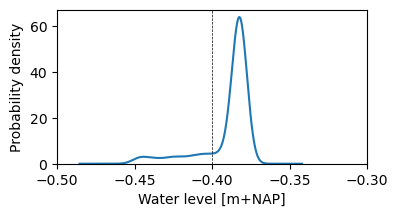

In [82]:
timeseries_simulation_results[-0.3][0.8][-0.3]['fan'][5][2019][4].plotter.plot_wl_distribution(kde=True)

In [41]:
wl_det_2019 = timeseries_simulation_results[-0.4]['robust']['fan'][1][2019][1].df.dropna().h_nzk.to_list()
wl_det_2019 += timeseries_simulation_results[-0.4]['robust']['fan'][1][2019][4].df.dropna().h_nzk.to_list()
wl_det_2019 += timeseries_simulation_results[-0.4]['robust']['fan'][1][2019][7].df.dropna().h_nzk.to_list()
wl_det_2019 += timeseries_simulation_results[-0.4]['robust']['fan'][1][2019][10].df.dropna().h_nzk.to_list()

wl_robust_2019 = timeseries_simulation_results[-0.4]['robust']['fan'][5][2019][1].df.dropna().h_nzk.to_list()
wl_robust_2019 += timeseries_simulation_results[-0.4]['robust']['fan'][5][2019][4].df.dropna().h_nzk.to_list()
wl_robust_2019 += timeseries_simulation_results[-0.4]['robust']['fan'][5][2019][7].df.dropna().h_nzk.to_list()
wl_robust_2019 += timeseries_simulation_results[-0.4]['robust']['fan'][5][2019][10].df.dropna().h_nzk.to_list()

wl_cvar_cons_2019 = timeseries_simulation_results[-0.3][0.99][-0.3]['fan'][5][2019][1].df.dropna().h_nzk.to_list()
wl_cvar_cons_2019 += timeseries_simulation_results[-0.3][0.99][-0.3]['fan'][5][2019][4].df.dropna().h_nzk.to_list()
wl_cvar_cons_2019 += timeseries_simulation_results[-0.3][0.99][-0.3]['fan'][5][2019][7].df.dropna().h_nzk.to_list()
wl_cvar_cons_2019 += timeseries_simulation_results[-0.3][0.99][-0.3]['fan'][5][2019][10].df.dropna().h_nzk.to_list()

wl_cvar_risk_2019 = timeseries_simulation_results[-0.3][0.8][-0.3]['fan'][5][2019][1].df.dropna().h_nzk.to_list()
wl_cvar_risk_2019 += timeseries_simulation_results[-0.3][0.8][-0.3]['fan'][5][2019][4].df.dropna().h_nzk.to_list()
wl_cvar_risk_2019 += timeseries_simulation_results[-0.3][0.8][-0.3]['fan'][5][2019][7].df.dropna().h_nzk.to_list()
wl_cvar_risk_2019 += timeseries_simulation_results[-0.3][0.8][-0.3]['fan'][5][2019][10].df.dropna().h_nzk.to_list()

In [42]:
wl_det_2020 = timeseries_simulation_results[-0.4]['robust']['fan'][1][2020][1].df.dropna().h_nzk.to_list()
wl_det_2020 += timeseries_simulation_results[-0.4]['robust']['fan'][1][2020][4].df.dropna().h_nzk.to_list()
wl_det_2020 += timeseries_simulation_results[-0.4]['robust']['fan'][1][2020][7].df.dropna().h_nzk.to_list()
wl_det_2020 += timeseries_simulation_results[-0.4]['robust']['fan'][1][2020][10].df.dropna().h_nzk.to_list()

wl_robust_2020 = timeseries_simulation_results[-0.4]['robust']['fan'][5][2020][1].df.dropna().h_nzk.to_list()
wl_robust_2020 += timeseries_simulation_results[-0.4]['robust']['fan'][5][2020][4].df.dropna().h_nzk.to_list()
wl_robust_2020 += timeseries_simulation_results[-0.4]['robust']['fan'][5][2020][7].df.dropna().h_nzk.to_list()
wl_robust_2020 += timeseries_simulation_results[-0.4]['robust']['fan'][5][2020][10].df.dropna().h_nzk.to_list()

wl_cvar_cons_2020 = timeseries_simulation_results[-0.3][0.99][-0.3]['fan'][5][2020][1].df.dropna().h_nzk.to_list()
wl_cvar_cons_2020 += timeseries_simulation_results[-0.3][0.99][-0.3]['fan'][5][2020][4].df.dropna().h_nzk.to_list()
wl_cvar_cons_2020 += timeseries_simulation_results[-0.3][0.99][-0.3]['fan'][5][2020][7].df.dropna().h_nzk.to_list()
wl_cvar_cons_2020 += timeseries_simulation_results[-0.3][0.99][-0.3]['fan'][5][2020][10].df.dropna().h_nzk.to_list()

wl_cvar_risk_2020 = timeseries_simulation_results[-0.3][0.8][-0.3]['fan'][5][2020][1].df.dropna().h_nzk.to_list()
wl_cvar_risk_2020 += timeseries_simulation_results[-0.3][0.8][-0.3]['fan'][5][2020][4].df.dropna().h_nzk.to_list()
wl_cvar_risk_2020 += timeseries_simulation_results[-0.3][0.8][-0.3]['fan'][5][2020][7].df.dropna().h_nzk.to_list()
wl_cvar_risk_2020 += timeseries_simulation_results[-0.3][0.8][-0.3]['fan'][5][2020][10].df.dropna().h_nzk.to_list()

In [43]:
wl_cvar_check = timeseries_simulation_results[-0.3][0.8][-0.395]['fan'][5][2019][1].df.dropna().h_nzk.to_list()
wl_cvar_check += timeseries_simulation_results[-0.3][0.8][-0.395]['fan'][5][2019][4].df.dropna().h_nzk.to_list()
wl_cvar_check += timeseries_simulation_results[-0.3][0.8][-0.395]['fan'][5][2019][7].df.dropna().h_nzk.to_list()
wl_cvar_check += timeseries_simulation_results[-0.3][0.8][-0.395]['fan'][5][2019][10].df.dropna().h_nzk.to_list()

In [44]:
wl_det_2021 = timeseries_simulation_results[-0.4]['robust']['fan'][1][2021][1].df.dropna().h_nzk.to_list()
wl_robust_2021 = timeseries_simulation_results[-0.4]['robust']['fan'][5][2021][1].df.dropna().h_nzk.to_list()
wl_cvar_cons_2021 = timeseries_simulation_results[-0.3][0.99][-0.3]['fan'][5][2021][1].df.dropna().h_nzk.to_list()
wl_cvar_risk_2021 = timeseries_simulation_results[-0.3][0.8][-0.3]['fan'][5][2021][1].df.dropna().h_nzk.to_list()

In [45]:
from matplotlib.ticker import PercentFormatter

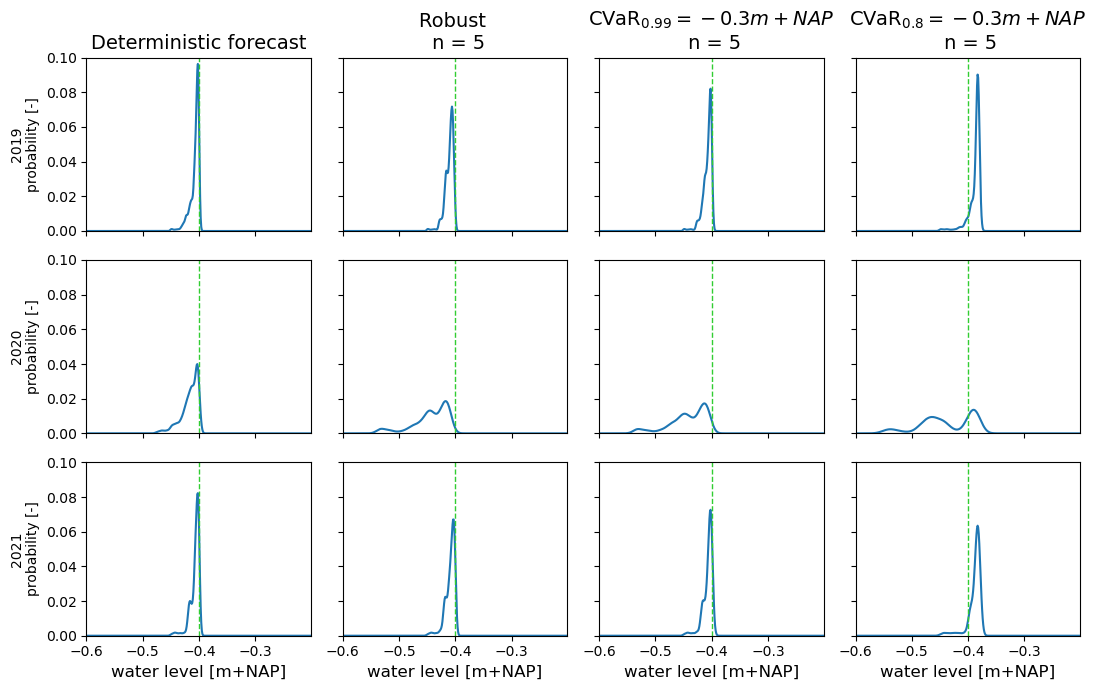

In [50]:
# plot the distributions of the water levels
fig, ax = plt.subplots(3, 4, figsize=(11, 7), sharey=True, sharex=True)

wl_det = {2019:wl_det_2019, 2020:wl_det_2020, 2021:wl_det_2021}
wl_robust = {2019:wl_robust_2019, 2020:wl_robust_2020, 2021:wl_robust_2021}
wl_cvar_cons = {2019:wl_cvar_cons_2019, 2020:wl_cvar_cons_2020, 2021:wl_cvar_cons_2021}
wl_cvar_risk = {2019:wl_cvar_risk_2019, 2020:wl_cvar_risk_2020, 2021:wl_cvar_risk_2021}
hrange = np.arange(-0.6, -0.2, 0.001)
for i, year in enumerate(years):
    det_kde = gaussian_kde(wl_det[year])(hrange)
    det_kde = det_kde / np.sum(det_kde)
    robust_kde = gaussian_kde(wl_robust[year])(hrange)
    robust_kde = robust_kde / np.sum(robust_kde)
    cvar_cons_kde = gaussian_kde(wl_cvar_cons[year])(hrange)
    cvar_cons_kde = cvar_cons_kde / np.sum(cvar_cons_kde)
    cvar_risk_kde = gaussian_kde(wl_cvar_risk[year])(hrange)
    cvar_risk_kde = cvar_risk_kde / np.sum(cvar_risk_kde)
    
    ax[i,0].plot(hrange, det_kde, label='deterministic')
    ax[i,0].set_xlim(min(hrange), max(hrange))
    ax[i,0].set_ylabel(f'{year}\nprobability [-]')
    ax[i,0].axvline(x=-0.4, color='limegreen', lw=1, ls='--')
    ax[i,0].set_ylim(0, 0.1)
    
    ax[i,1].plot(hrange, robust_kde, label='robust')
    ax[i,1].set_xlim(min(hrange), max(hrange))
    ax[i,1].axvline(x=-0.4, color='limegreen', lw=1, ls='--')
    ax[i,1].set_ylim(0, 0.1)

    ax[i,2].plot(hrange, cvar_cons_kde, label='cvar$_{0.99}$ = -0.3 m+NAP (5)')
    ax[i,2].set_xlim(min(hrange), max(hrange))
    ax[i,2].axvline(x=-0.4, color='limegreen', lw=1, ls='--')
    ax[i,2].set_ylim(0, 0.1)
    
    ax[i,3].plot(hrange, cvar_risk_kde, label='cvar$_{0.8}$ = -0.3 m+NAP (5)')
    ax[i,3].set_xlim(min(hrange), max(hrange))
    ax[i,3].axvline(x=-0.4, color='limegreen', lw=1, ls='--')
    ax[i,3].set_ylim(0, 0.1)

    if i==0:
        ax[i,0].set_title('Deterministic forecast', fontsize=14)
        ax[i,1].set_title('Robust \n n = 5', fontsize=14)
        ax[i,2].set_title('CVaR$_{0.99} = -0.3m+NAP$\n n = 5', fontsize=14)
        ax[i,3].set_title('CVaR$_{0.8} = -0.3m+NAP$\n n = 5', fontsize=14)
    if i==2:
        ax[i,0].set_xlabel('water level [m+NAP]', fontsize=12)
        ax[i,1].set_xlabel('water level [m+NAP]', fontsize=12)
        ax[i,2].set_xlabel('water level [m+NAP]', fontsize=12)
        ax[i,3].set_xlabel('water level [m+NAP]', fontsize=12)

fig.tight_layout()
fig.savefig('wl_distributions.pdf', bbox_inches='tight')


In [46]:
rws_datapath = Path().cwd().parent.parent.parent / 'data' / 'ark data' / 'wl_obs_df.csv'
rws_data = pd.read_csv(rws_datapath)
rws_data.loc[:, 'WAARNEMINGDATUM'] = pd.to_datetime(rws_data.WAARNEMINGDATUM, format='%Y-%m-%d')
rws_data.head()

C:\Users\Heijden\AppData\Local\Temp\ipykernel_17892\1685194876.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rws_data.loc[:, 'WAARNEMINGDATUM'] = pd.to_datetime(rws_data.WAARNEMINGDATUM, format='%Y-%m-%d')


,BUITHZN,IJMDBNN,WAARNEMINGDATUM,WAARNEMINGTIJD
0,-0.47,-0.48,2019-01-01,00:00:00
1,-0.46,-0.49,2019-01-01,00:10:00
2,-0.46,-0.49,2019-01-01,00:20:00
3,-0.47,-0.47,2019-01-01,00:30:00
4,-0.45,-0.48,2019-01-01,00:40:00


In [47]:
station = 'BUITHZN'
# station = 'IJMDBNN'
wl_obs_2019 = rws_data.loc[(rws_data.WAARNEMINGDATUM.dt.year==2019)]
wl_obs_2019 = wl_obs_2019.loc[(wl_obs_2019.WAARNEMINGDATUM.dt.month==1) | (wl_obs_2019.WAARNEMINGDATUM.dt.month==4) | (wl_obs_2019.WAARNEMINGDATUM.dt.month==7) | (wl_obs_2019.WAARNEMINGDATUM.dt.month==10)]
wl_obs_2019 = wl_obs_2019.loc[:,station].to_list()

wl_obs_2020 = rws_data.loc[(rws_data.WAARNEMINGDATUM.dt.year==2020)]
wl_obs_2020 = wl_obs_2020.loc[(wl_obs_2020.WAARNEMINGDATUM.dt.month==1) | (wl_obs_2020.WAARNEMINGDATUM.dt.month==4) | (wl_obs_2020.WAARNEMINGDATUM.dt.month==7) | (wl_obs_2020.WAARNEMINGDATUM.dt.month==10)]
wl_obs_2020 = wl_obs_2020.loc[:,station].to_list()

wl_obs_2021 = rws_data.loc[(rws_data.WAARNEMINGDATUM.dt.year==2021)]
wl_obs_2021 = wl_obs_2021.loc[(wl_obs_2021.WAARNEMINGDATUM.dt.month==1)]
wl_obs_2021 = wl_obs_2021.loc[:,station].to_list()

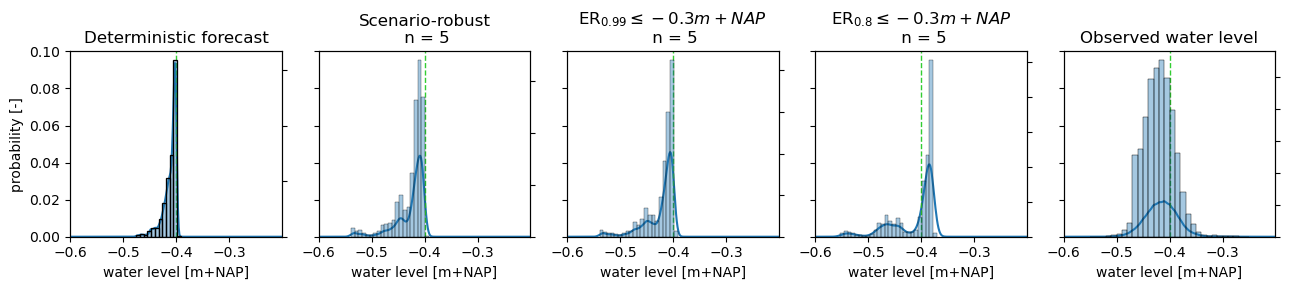

In [48]:
# plot the distributions of the water levels
fig, ax = plt.subplots(1, 5, figsize=(13, 3), sharey=True, sharex=True)

wl_det_tot = wl_det_2019 + wl_det_2020 + wl_det_2021
wl_robust_tot = wl_robust_2019 + wl_robust_2020 + wl_robust_2021
wl_cvar_cons_tot = wl_cvar_cons_2019 + wl_cvar_cons_2020 +wl_cvar_cons_2021
wl_cvar_risk_tot = wl_cvar_risk_2019 + wl_cvar_risk_2020 +wl_cvar_risk_2021
wl_obs_tot = wl_obs_2019 + wl_obs_2020 + wl_obs_2021
hrange = np.arange(-0.6, -0.2, 0.0014)

det_kde = gaussian_kde(wl_det_tot)(hrange)
det_kde = det_kde / np.sum(det_kde)
robust_kde = gaussian_kde(wl_robust_tot)(hrange)
robust_kde = robust_kde / np.sum(robust_kde)
cvar_cons_kde = gaussian_kde(wl_cvar_cons_tot)(hrange)
cvar_cons_kde = cvar_cons_kde / np.sum(cvar_cons_kde)
cvar_risk_kde = gaussian_kde(wl_cvar_risk_tot)(hrange)
cvar_risk_kde = cvar_risk_kde / np.sum(cvar_risk_kde)
obs_kde = gaussian_kde(wl_obs_tot, bw_method=0.18)(hrange)
obs_kde = obs_kde / np.sum(obs_kde)

bw=0.007
ax_ = ax[0].twinx()
sns.histplot(wl_det_tot, binwidth=bw, stat='density', ax=ax_, color='C0', alpha=0.4)
ax_.set_ylabel('')
ax_.set_yticklabels('')
ax[0].plot(hrange, det_kde, label='deterministic')
ax[0].set_xlim(min(hrange), max(hrange))
ax[0].set_ylabel(f'probability [-]')
ax[0].axvline(x=-0.4, color='limegreen', lw=1, ls='--')
ax[0].set_ylim(0, 0.1)
ax[0].set_xlabel('water level [m+NAP]')
ax[0].set_title('Deterministic forecast', fontsize=12)

ax_ = ax[1].twinx()
sns.histplot(wl_robust_tot, binwidth=bw, stat='density', ax=ax_, color='C0', alpha=0.4)
ax_.set_ylabel('')
ax_.set_yticklabels('')
ax[1].plot(hrange, robust_kde, label='robust')
ax[1].set_xlim(min(hrange), max(hrange))
ax[1].axvline(x=-0.4, color='limegreen', lw=1, ls='--')
ax[1].set_ylim(0, 0.1)
ax[1].set_xlabel('water level [m+NAP]')
ax[1].set_title('Scenario-robust\n n = 5', fontsize=12)

ax_ = ax[2].twinx()
sns.histplot(wl_cvar_cons_tot, binwidth=bw, stat='density', ax=ax_, color='C0', alpha=0.4)
ax_.set_ylabel('')
ax_.set_yticklabels('')
ax[2].plot(hrange, cvar_cons_kde, label='cvar$_{0.99}$ = -0.3 m+NAP (5)')
ax[2].set_xlim(min(hrange), max(hrange))
ax[2].axvline(x=-0.4, color='limegreen', lw=1, ls='--')
ax[2].set_ylim(0, 0.1)
ax[2].set_xlabel('water level [m+NAP]')
ax[2].set_title('ER$_{0.99} \leq -0.3m+NAP$\n n = 5', fontsize=12)

ax_ = ax[3].twinx()
sns.histplot(wl_cvar_risk_tot, binwidth=bw, stat='density', ax=ax_, color='C0', alpha=0.4)
ax_.set_ylabel('')
ax_.set_yticklabels('')
ax[3].plot(hrange, cvar_risk_kde, label='cvar$_{0.8}$ = -0.3 m+NAP (5)')
ax[3].set_xlim(min(hrange), max(hrange))
ax[3].axvline(x=-0.4, color='limegreen', lw=1, ls='--')
ax[3].set_ylim(0, 0.1)
ax[3].set_xlabel('water level [m+NAP]')
ax[3].set_title('ER$_{0.8} \leq -0.3m+NAP$\n n = 5', fontsize=12)

ax_ = ax[4].twinx()
sns.histplot(wl_obs_tot, binwidth=0.01, stat='density', ax=ax_, color='C0', alpha=0.4)
ax_.set_ylabel('')
ax_.set_yticklabels('')
ax[4].plot(hrange, obs_kde, label='Observations')
ax[4].set_xlim(min(hrange), max(hrange))
ax[4].axvline(x=-0.4, color='limegreen', lw=1, ls='--')
ax[4].set_ylim(0, 0.1)
ax[4].set_xlabel('water level [m+NAP]')
ax[4].set_title('Observed water level', fontsize=12)

    # if i==0:
    #     ax[i,0].set_title('Deterministic', fontsize=14)
    #     ax[i,1].set_title('Robust', fontsize=14)
    #     ax[i,2].set_title('CVaR$_{0.99} = -0.3m+NAP$', fontsize=14)
    #     ax[i,3].set_title('CVaR$_{0.8} = -0.3m+NAP$', fontsize=14)
    # if i==2:
    #     ax[i,0].set_xlabel('water level [m+NAP]', fontsize=12)
    #     ax[i,1].set_xlabel('water level [m+NAP]', fontsize=12)
    #     ax[i,2].set_xlabel('water level [m+NAP]', fontsize=12)
    #     ax[i,3].set_xlabel('water level [m+NAP]', fontsize=12)

fig.tight_layout()
fig.savefig('yearly_wl_distributions.pdf', bbox_inches='tight')


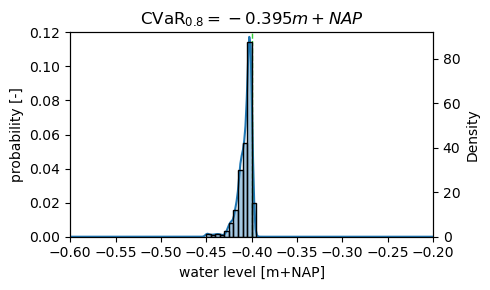

In [102]:
cvar_check_kde = gaussian_kde(wl_cvar_check)(hrange)
cvar_check_kde = cvar_check_kde / np.sum(cvar_check_kde)

fig, ax = plt.subplots(1, 1, figsize=(5, 3), sharey=True, sharex=True)
ax_ = ax.twinx()
sns.histplot(wl_cvar_check, binwidth=0.005, stat='density', ax=ax_, color='C0', alpha=0.4)
ax.plot(hrange, cvar_check_kde, label='cvar$_{0.8}$ = -0.395 m+NAP (5)')
ax.set_ylabel(f'probability [-]')
ax.set_xlabel('water level [m+NAP]')
ax.set_title('CVaR$_{0.8} = -0.395m+NAP$', fontsize=12)
ax.set_xlim(-0.6, -0.2)
ax.set_ylim(0, 0.12)
ax.axvline(x=-0.4, color='limegreen', lw=1, ls='--')
fig.tight_layout()

# Check runtimes

In [69]:
alphas = [0.99, 0.9, 0.8]
cvars = [-0.395, -0.3]
shapes = ['fan', 'tree']
n_scenarios = [3, 5]
wl_root = [-0.3]

years = [2019, 2020, 2021]
months = [1, 4, 7, 10]

In [70]:
def get_runtimes(alpha, cvar, shape, n, year, month):
    cvar = str(cvar).replace('-', '')
    datapath = tspath / 'high wl' / f'{year}-{month}' / f'cvar_{alpha}_{cvar}_energy_{n}_{shape}' / 'timesteps'
    filelist = list(datapath.glob('*.pkl'))
    creation_times = np.array([os.path.getmtime(tspath / file) for file in filelist])
    return np.diff(creation_times) / 3600 # in hours

In [74]:
runtimes = {}
runtimes_total = []
summed_runtime = {}
summed_total_runtime = 0

for alpha in alphas:
    runtimes[alpha] = {}
    summed_runtime[alpha] = {}
    for cvar in cvars:
        runtimes[alpha][cvar] = {}
        summed_runtime[alpha][cvar] = {}
        for shape in shapes:
            runtimes[alpha][cvar][shape] = {}
            summed_runtime[alpha][cvar][shape] = {}
            for n in n_scenarios:
                runtimes[alpha][cvar][shape][n] = {}
                summed_runtime[alpha][cvar][shape][n] = {}
                for year in years:
                    runtimes[alpha][cvar][shape][n][year] = {}
                    summed_runtime[alpha][cvar][shape][n][year] = {}
                    for month in months:
                        runt_ = get_runtimes(alpha, cvar, shape, n, year, month)
                        runt_ = runt_[runt_ >= 0]
                        runtimes[alpha][cvar][shape][n][year][month] = runt_[runt_<= 48]
                        summed_runtime[alpha][cvar][shape][n][year][month] = np.sum(runtimes[alpha][cvar][shape][n][year][month])
                        summed_total_runtime += summed_runtime[alpha][cvar][shape][n][year][month]
                        runtimes_total.append(runt_)
runtimes_total = np.concatenate(runtimes_total)

In [75]:
n_months_simulated = len(alphas) * len(cvars) * len(shapes) * len(n_scenarios) * (2 * len(months) + 1)
average_runtime = summed_total_runtime / n_months_simulated
print(f'Average runtime per scenario month: {average_runtime:.2f} hours, months simulated: {n_months_simulated}')

Average runtime per scenario month: 21.54 hours, months simulated: 216


In [156]:
# Now for only january 2021
average_2021_runtime = sum([summed_runtime[alpha][cvar][shape][n][2021][1] for alpha in alphas for cvar in cvars for shape in shapes for n in n_scenarios]) / (len(alphas) * len(cvars) * len(shapes) * len(n_scenarios))
print(f'Average runtime per scenario month: {average_2021_runtime:.2f} hours, months simulated: {len(alphas) * len(cvars) * len(shapes) * len(n_scenarios)}')

Average runtime per scenario month: 34.94 hours, months simulated: 24


In [158]:
average_2021_runtime_fan = sum([summed_runtime[alpha][cvar]['fan'][5][2021][1] for alpha in alphas for cvar in cvars]) / (len(alphas) * len(cvars))
average_2021_runtime_tree = sum([summed_runtime[alpha][cvar]['tree'][5][2021][1] for alpha in alphas for cvar in cvars]) / (len(alphas) * len(cvars))
print(f'Average runtime per scenario month fan approach: {average_2021_runtime_fan:.2f} hours, months simulated: {len(alphas) * len(cvars)}')
print(f'Average runtime per scenario month tree approach: {average_2021_runtime_tree:.2f} hours, months simulated: {len(alphas) * len(cvars)}')

Average runtime per scenario month fan approach: 58.18 hours, months simulated: 6
Average runtime per scenario month tree approach: 26.84 hours, months simulated: 6


(-1.0, 10.0)

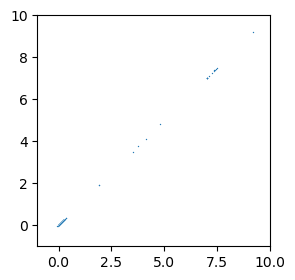

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
# sns.histplot(np.concatenate(runtimes_total) / 60 / 60, ax=ax, bins=[-100, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1000])
# ax.set_xlim(-1, 1000)
sns.scatterplot(x=runtimes_total, y=runtimes_total, ax=ax, s=1)
ax.set_xlim(-1, 10)
ax.set_ylim(-1, 10)

In [38]:
for thresh in [0, 0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 12, 24, 48, 72, 168, 10000]:
    print(f'{thresh} hours: {np.sum(runtimes_total >= thresh)}')

0 hours: 146344
0.25 hours: 11666
0.5 hours: 130
0.75 hours: 130
1 hours: 130
2 hours: 128
3 hours: 128
4 hours: 126
5 hours: 124
12 hours: 103
24 hours: 93
48 hours: 80
72 hours: 73
168 hours: 51
10000 hours: 0


In [60]:
np.quantile(runtimes_total, 0.9993)

12.054467138881058

(0.0, 1000.0)

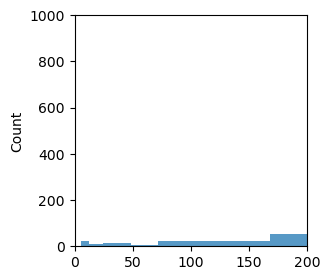

In [53]:
bins = [0, 0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 12, 24, 48, 72, 168, 10000]
fig, ax = plt.subplots(1, 1, figsize=(3,3))
sns.histplot(runtimes_total, ax=ax, bins=bins)
ax.set_xlim(0, 200)
ax.set_ylim(0,1000)

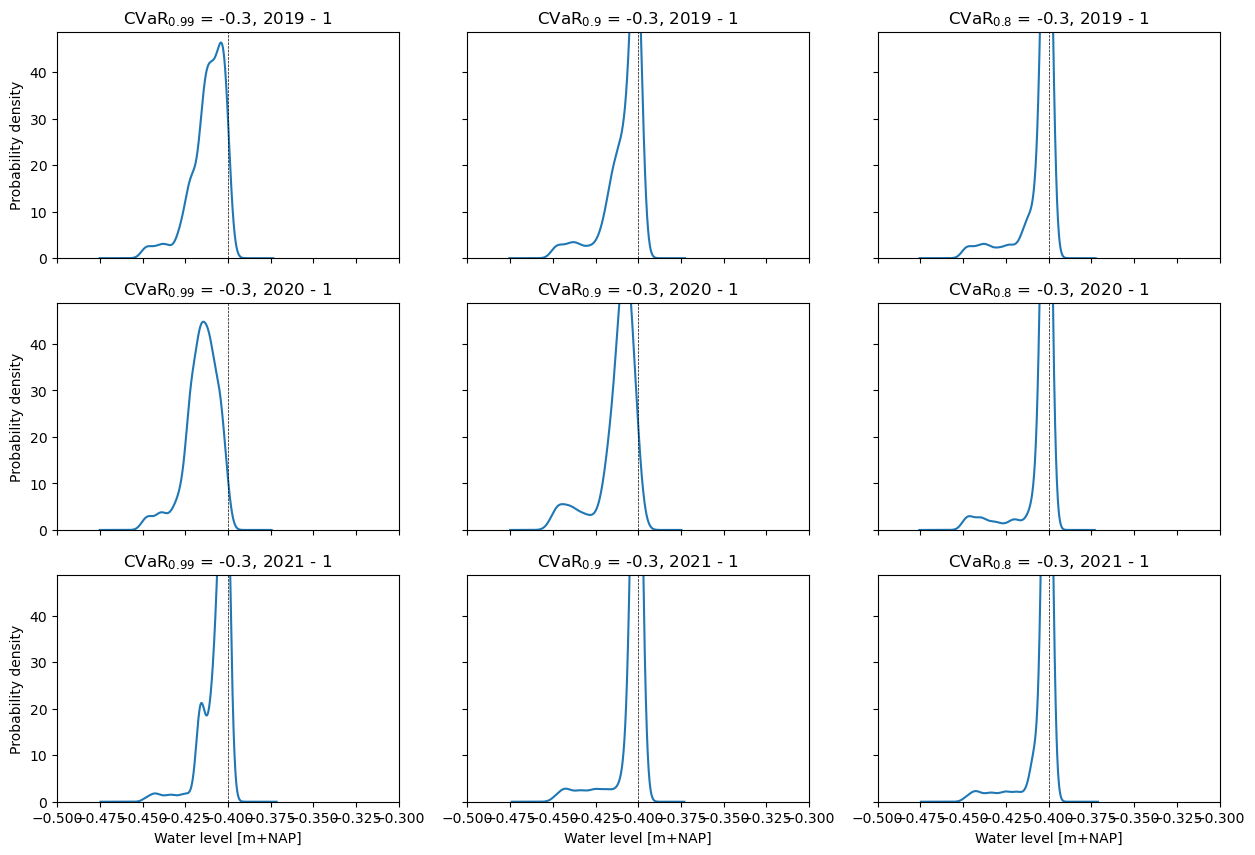

In [54]:
months = [1, 1, 1]
years = [2019, 2020, 2021]

wl = -0.4
alphas = [0.99, 0.9, 0.8]
cvars = [-0.3, -0.3, -0.3]
shapes = ['fan', 'fan', 'fan']
n_scenarios = [3, 3, 3]

fig, ax = plt.subplots(3, 3, figsize=(15, 10), sharex=True, sharey=True)
for i in range(3):
    for j in range(3):
        # try:
        timeseries_simulation_results[wl][alphas[j]][cvars[j]][shapes[j]][n_scenarios[j]][years[i]][months[i]].plotter.plot_wl_distribution(ax=ax[i, j], kde=True)
        title = f'CVaR$_{{{alphas[j]}}}$ = {cvars[j]}'
        # if i == 0:
        title += f', {years[i]} - {months[i]}'
        ax[i, j].set_title(title)
        # ax[i, j].set_title(f'CVaR$_{{{alphas[j]}}}$ = {cvars[j]}')
        # except:
        #     pass

# timeseries_simulation_results[-0.4][0.9][-0.395]['fan'][3][2020][7].plot_wl_distribution()
# timeseries_simulation_results[-0.3]['robust']['fan'][3][2020][7].plot_wl_distribution()

Text(0, 0.5, 'Cumulative waterbalance error [mm]')

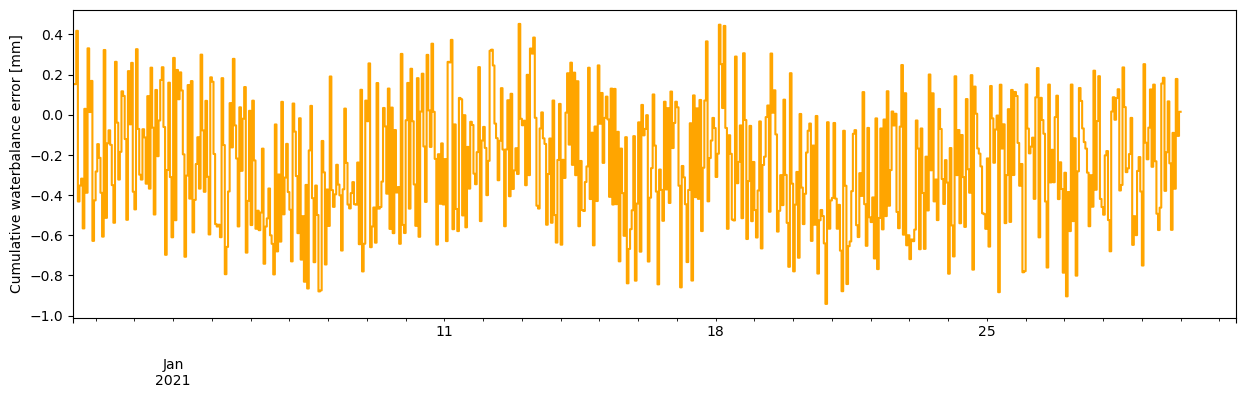

In [891]:
df = timeseries_simulation_results[-0.3][0.8][-0.395]['fan'][3][2021][1].df.astype(float)
Q_in = (df['Q_wb'] + df['Q_ark']) * 3600
Q_out = (df['Q_pump'] + df['Q_gate']) * 3600


volume_in = Q_in.dropna().cumsum()
volume_out = Q_out.dropna().cumsum()
# fig, ax = plt.subplots(1, 1, figsize=(15, 4))
# volume_in.plot(drawstyle='steps-post', ax=ax, color='blue', label='Q_in')
# volume_out.plot(drawstyle='steps-post', ax=ax, color='red', label='Q_out')

dV = Q_in - Q_out
h = df.loc[dV.index, 'h_nzk'].round(3)
dh = h.diff()
waterbalance = dV - dh * 36 * 10e6

fig, ax = plt.subplots(1, 1, figsize=(15, 4))
(waterbalance.cumsum() / (36 * 10e6) * 1000).plot(drawstyle='steps-post', ax=ax, color='orange', label='cumulative waterbalance error')
ax.set_ylabel('Cumulative waterbalance error [mm]')

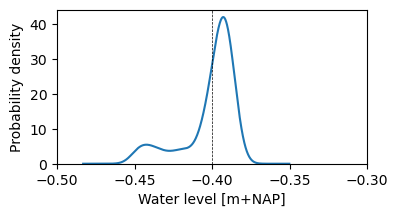

In [766]:
def calc_wb(df):
    ind = df.Q_pump.dropna().index
    df = df.loc[ind]
    Q_ark = df.Q_ark.sum()
    Q_pump = df.Q_pump.sum()
    Q_gate = df.Q_gate.sum()
    Q_wb = df.Q_wb.sum()
    dh_nzk = df.h_nzk.dropna()[-1] - df.h_nzk[0]

    return Q_ark + Q_pump + Q_gate + Q_wb, dh_nzk

timeseries_simulation_results[-0.3][0.8][-0.3]['fan'][3][2020][1].plot_wl_distribution()

In [767]:
timeseries_simulation_results[-0.3][0.8][-0.3]['fan'][3][2020][1].df.dropna()

,h_nzk,Q_gate,Q_pump,Q_wb,Q_ark,E_act,E_dam,h_ns,p_dam,p_idm
2020-01-01 10:00:00+01:00,-0.45,0,0,0,0,0,0,0,0,0
2020-01-01 11:00:00+01:00,-0.4499,0.0,0.0,4.62,6.34,0.0,0,-0.103,30.34,29.8
2020-01-01 12:00:00+01:00,-0.4497,0.0,0.0,5.18,16.29,0.0,0,-0.373,30.99,32.05
2020-01-01 13:00:00+01:00,-0.4494,-0.0,0.0,9.16,17.71,0.0,0,-0.487,30.04,31.52
2020-01-01 14:00:00+01:00,-0.4491,0.0,0.0,9.86,21.3,0.0,0,-0.615,30.75,30.46
...,...,...,...,...,...,...,...,...,...,...
2020-01-15 04:00:00+01:00,-0.3906,0.0,197.96,70.68,30.72,2.216472,0.336859,0.022,11.1,34.42
2020-01-15 05:00:00+01:00,-0.3906,0.0,107.55,70.03,34.1,1.130294,0.516896,0.223,19.29,30.11
2020-01-15 06:00:00+01:00,-0.3905,0.0,89.21,64.72,29.96,1.612271,0.224576,0.938,28.56,29.66
2020-01-15 07:00:00+01:00,-0.3904,0.0,56.86,40.61,30.78,1.254435,0.01186,1.378,38.26,35.39


In [771]:
q, dh = calc_wb(timeseries_simulation_results[-0.4][0.8][-0.3]['fan'][3][2019][1].df)

0.045399999999999996

In [773]:
q * 3600 / (36 * 10e6)

0.9290194000000002

In [732]:
timeseries_simulation_results[-0.4][0.99][-0.3]['fan'][3][2019][10].df

,h_nzk,Q_gate,Q_pump,Q_wb,Q_ark,E_act,E_dam,h_ns,p_dam,p_idm
2019-10-01 10:00:00+02:00,-0.45,0,0,0,0,0,0,0,0,0
2019-10-01 11:00:00+02:00,-0.4483,0.0,8.81,137.78,42.2,0.100389,0,0.527,44.92,NaN
2019-10-01 12:00:00+02:00,-0.4468,0.0,15.17,126.16,38.02,0.158081,0,0.425,42.17,NaN
2019-10-01 13:00:00+02:00,-0.4455,0.0,30.22,124.84,35.35,0.189342,0,0.018,41.04,NaN
2019-10-01 14:00:00+02:00,-0.4438,0.0,22.62,161.15,30.52,0.050795,0,-0.313,39.49,NaN
...,...,...,...,...,...,...,...,...,...,...
2019-10-31 06:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-31 07:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-31 08:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-31 09:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


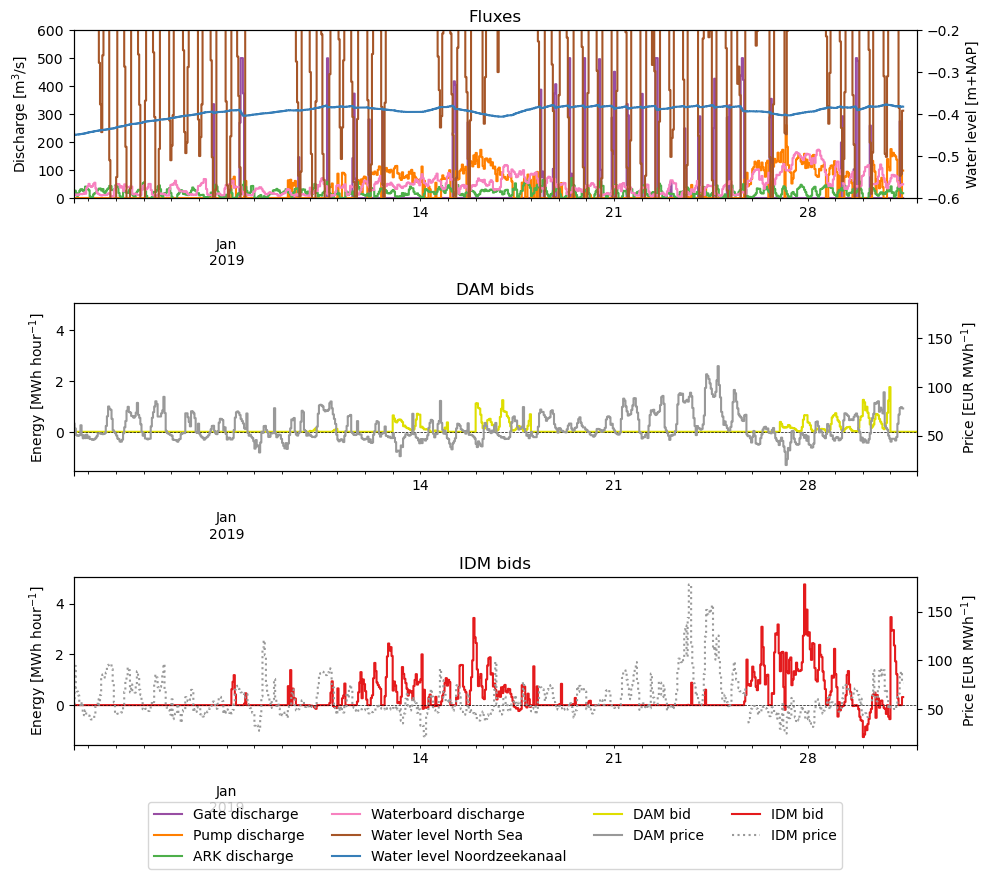

In [97]:
timeseries_simulation_results[-0.3][0.8][-0.3]['fan'][5][2019][1].plot_fluxes()

In [88]:
timeserie_dfs[-0.4][0.99][-0.395]['fan'][3][2019][1]

,h_nzk,Q_gate,Q_pump,Q_wb,Q_ark,E_act,E_dam,h_ns,p_dam,p_idm
2019-01-01 10:00:00+01:00,-0.45,0,0,0,0,0,0,0,0,0
2019-01-01 11:00:00+01:00,-0.4497,0.0,0.0,9.35,25.07,0.0,0,0.577,62.62,55.55
2019-01-01 12:00:00+01:00,-0.4493,0.0,0.0,11.84,26.38,0.0,0,1.187,57.4,94.29
2019-01-01 13:00:00+01:00,-0.449,0.0,0.0,12.5,18.27,0.0,0,1.41,50.76,70.1
2019-01-01 14:00:00+01:00,-0.4488,0.0,0.0,11.81,7.37,0.0,0,1.333,49.92,67.96
...,...,...,...,...,...,...,...,...,...,...
2019-02-02 19:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2019-02-02 20:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2019-02-02 21:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2019-02-02 22:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [79]:
cvars = [0.99, 0.9, 0.8]


array([ 1,  4,  7, 10])

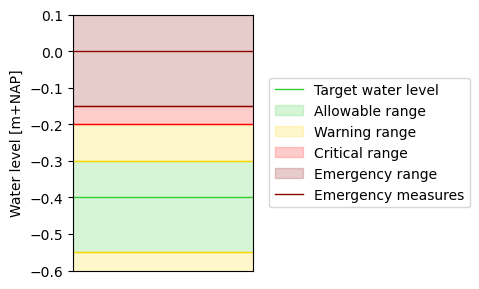

In [312]:
# make the NZK-ARK regime plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
x = np.arange(0, 1.1, 0.1)

lw = 1
ls = '-'
# Safe water levels
ax.axhline(y=-0.4, color='limegreen', lw=lw, ls=ls, label='Target water level')
ax.fill_between(x, -0.55, -0.3, color='limegreen', alpha=0.2, label='Allowable range')
# ax.text(0.5, -0.35, 'Safe water level range', ha='center', va='center', color='limegreen', fontsize=12)#, fontweight='bold')
# ax.text(0.5, -0.4, 'Target water level', ha='center', va='center')

# Warning water levels
ax.fill_between(x, -0.3, -0.2, color='gold', alpha=0.2, label='Warning range')
ax.axhline(y=-0.3, color='gold', lw=lw, ls=ls)
ax.fill_between(x, -0.6, -0.55, color='gold', alpha=0.2)
ax.axhline(y=-0.55, color='gold', lw=lw, ls=ls)

# Alarm water levels
ax.fill_between(x, -0.2, -0.15, color='red', alpha=0.2, label='Critical range')
ax.axhline(y=-0.2, color='red', lw=lw, ls=ls)

# Critical water levels
ax.fill_between(x, -0.15, 0.1, color='darkred', alpha=0.2, label='Emergency range')
ax.axhline(y=-0.15, color='darkred', lw=lw, ls=ls, label='Emergency measures')
ax.axhline(y=0, color='darkred', lw=lw, ls=ls)

ax.set_xlim(x[0], x[-1])
ax.set_ylim(-0.6, 0.1)
ax.set_ylabel('Water level [m+NAP]')

# Plot the legend on the right of the figure
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fancybox=True)

# Remove the x axis
ax.xaxis.set_visible(False)
fig.tight_layout()
plt.savefig('nzk_ark_regime.pdf', bbox_inches='tight', dpi=300)